In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt


from utils import *
import geopandas as gpd
import matplotlib.patches as mpatches
import json

# initialize random generator
rng = np.random.default_rng()

# Datasets

In [3]:
##### Warren County...
# path to dem
warren_dem_path = r'../data/warren/dem_single_warren.tif'

# path to geologic map
warren_geo_path = r'../data/warren/geo_warren.tif'

# path to geologic map integer metadata
warren_geo_meta = r'../data/warren/geo_warren.json'


##### Hardin County
# path to dem
hardin_dem_path = r'../data/hardin/dem_single_hardin.tif'

# path to geologic map (masked to only show same geologic units as in warren county)
hardin_geo_path = r'../data/hardin/geo_hardin_masked.tif'

# path to geologic map integer metadata
hardin_geo_meta = r'../data/hardin/geo_hardin_masked.json'

# Dataset Consistency

In [4]:
##### Warren County Datasets....
with rasterio.open(warren_dem_path) as dem:
    print('Warren County DEM')
    for key, value in dem.meta.items():
        print(f"{key}: {value}")
    print(f"Resolution: {dem.res}")
    print(f"Linear unit: {geotiff_linear_units(dem)}")

with rasterio.open(warren_geo_path) as geo:
    print('\nWarren County Geologic Map')
    for key, value in geo.meta.items():
        print(f"{key}: {value}")
    print(f"Resolution: {geo.res}")
    print(f"Linear unit: {geotiff_linear_units(geo)}")

Warren County DEM
driver: GTiff
dtype: float32
nodata: 3.3999999521443642e+38
width: 22037
height: 18323
count: 1
crs: EPSG:3089
transform: | 5.00, 0.00, 4665290.00|
| 0.00,-5.00, 3570295.00|
| 0.00, 0.00, 1.00|
Resolution: (5.0, 5.0)
Linear unit: US survey foot

Warren County Geologic Map
driver: GTiff
dtype: uint8
nodata: 0.0
width: 22037
height: 18323
count: 1
crs: EPSG:3089
transform: | 5.00, 0.00, 4665290.00|
| 0.00,-5.00, 3570295.00|
| 0.00, 0.00, 1.00|
Resolution: (5.0, 5.0)
Linear unit: US survey foot


In [5]:
##### Hardin County Datasets....
with rasterio.open(hardin_dem_path) as dem:
    print('Hardin County DEM')
    for key, value in dem.meta.items():
        print(f"{key}: {value}")
    print(f"Resolution: {dem.res}")
    print(f"Linear unit: {geotiff_linear_units(dem)}")

with rasterio.open(hardin_geo_path) as geo:
    print('\nHardin County Geologic Map')
    for key, value in geo.meta.items():
        print(f"{key}: {value}")
    print(f"Resolution: {geo.res}")
    print(f"Linear unit: {geotiff_linear_units(geo)}")

Hardin County DEM
driver: GTiff
dtype: float32
nodata: 3.3999999521443642e+38
width: 45602
height: 46081
count: 1
crs: EPSG:3089
transform: | 5.00, 0.00, 4768395.00|
| 0.00,-5.00, 3890550.00|
| 0.00, 0.00, 1.00|
Resolution: (5.0, 5.0)
Linear unit: US survey foot

Hardin County Geologic Map
driver: GTiff
dtype: uint8
nodata: 0.0
width: 45602
height: 46081
count: 1
crs: EPSG:3089
transform: | 5.00, 0.00, 4768395.00|
| 0.00,-5.00, 3890550.00|
| 0.00, 0.00, 1.00|
Resolution: (5.0, 5.0)
Linear unit: US survey foot


# Dataset Visualizations

## Warren County

### DEM

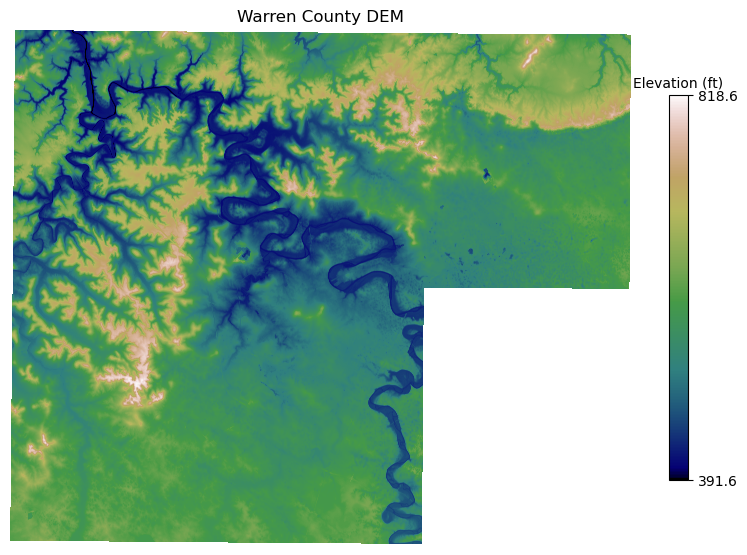

In [6]:
##### Warren County DEM
with rasterio.open(warren_dem_path) as dem:

    data = dem.read(1, masked=True)

    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.imshow(data, cmap='gist_earth')
    cbar = fig.colorbar(cax, shrink=0.5, ticks=None)
    cbar.set_ticks(ticks=[np.min(data), np.max(data)])
    cbar.ax.set_title('Elevation (ft)', fontdict={'fontsize':10, 'horizontalalignment':'center'})
    ax.set_axis_off()
    ax.set_title('Warren County DEM')
    plt.show()

In [33]:
def plot_dem_histogram(input_path, title=None):
    
    fig, ax = plt.subplots(figsize=(4,4))

    with rasterio.open(input_path) as dem:
        data = dem.read(1, masked=True)
        data = data.filled(np.nan)
        ax.hist(data.flatten(), bins=50, density=True, align='mid', linewidth=0.5, edgecolor='k')
        dem_min = str(round(np.nanmin(data), 1))
        dem_median = str(round(np.nanmedian(data), 1))
        dem_mean = str(round(np.nanmean(data), 1))
        dem_max = str(round(np.nanmax(data), 1))
        label=f"Min: {dem_min}\nMedian: {dem_median}\nMean: {dem_mean}\nMax: {dem_max}"
        ax.text(0.99, 0.99, label, ha='right', va='top', transform=ax.transAxes)
        ax.set_xlabel('Elevation (ft)')
        ax.set_ylabel('Density')
        ax.set_title(title, style='italic')
        plt.show()

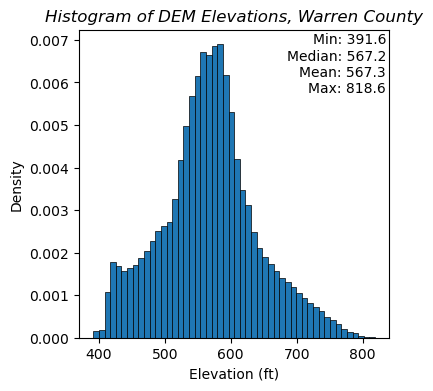

In [31]:
##### Warren County DEM Histogram

plot_dem_histogram(warren_dem_path, 'Histogram of DEM Elevations, Warren County')

### Surficial Geologic Map

In [56]:
##### Warren County Integer-to-Symbol Encoding/Decoding

# open json metadata for map unit to integer mapping
with open(warren_geo_meta, 'r') as geo_meta:
    geo_labels = json.load(geo_meta)

# reverse mapping as integer (key) to map unit (value)
geo_ints = {value:key for key, value in geo_labels.items()}

# define custom rgb colors for map units (from KGS standardized colors)
geo_labels_rgb = {'Qr':(176,172,214), 
                  'af1':(99,101,102), 
                  'Qal':(253,245,164), 
                  'Qaf':(255,161,219), 
                  'Qat':(249,228,101), 
                  'Qc':(214,201,167), 
                  'Qca':(196,157,131)}

# reverse color mapping to integer and rgb percentage (rgb/255)
geo_ints_colors = {geo_labels[key]:tuple(v/255 for v in value) for key, value in geo_labels_rgb.items()}

# create custom color map
cmap = plt.matplotlib.colors.ListedColormap([geo_ints_colors[key] for key in geo_ints.keys()])

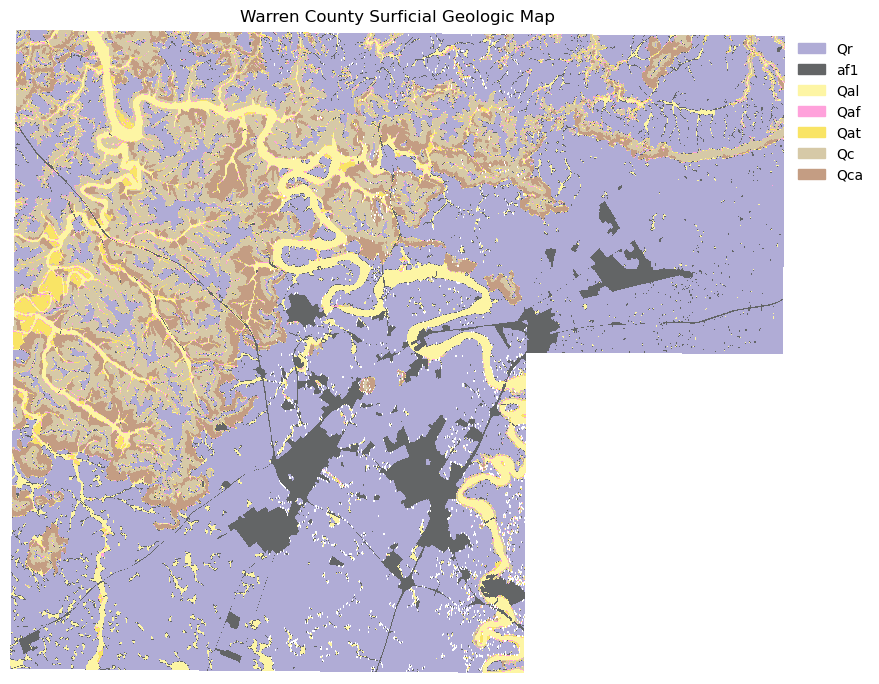

In [6]:
##### Warren County Geologic Map

# open geologic map image and plot...
with rasterio.open(warren_geo_path) as geo:

    # read data (mask nodata values)
    data = geo.read(1, masked=True)

    # plot image...
    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.imshow(data, cmap=cmap)

    # create custom legend items
    handles = [mpatches.Patch(color=geo_ints_colors[key], label=geo_ints[key]) for key in geo_ints.keys()]
    ax.legend(handles=handles, bbox_to_anchor=(1,1), loc='upper left', frameon=False)

    # adjust plot elements
    ax.set_axis_off()
    ax.set_title('Warren County Surficial Geologic Map')
    plt.show()

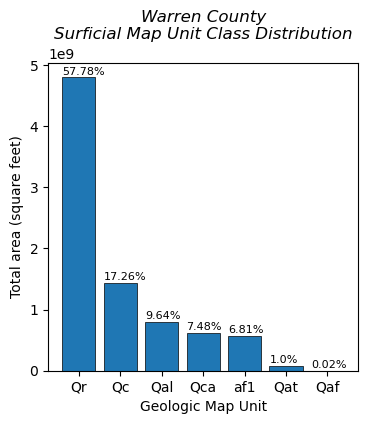

In [7]:
##### Warren County Geologic Map Unit Class Distribution

fig, ax = plt.subplots(figsize=(4,4))

with rasterio.open(warren_geo_path) as geo:

    data = geo.read(1, masked=True).compressed()
    x_res, y_res = geo.res

    int_labels, pixel_counts = np.unique(data, return_counts=True)

    int_counts = dict(zip(int_labels, pixel_counts))

    label_areas = {geo_ints[key]:int_counts[key]*x_res*y_res for key in int_counts.keys()}

    label_areas = dict(sorted(label_areas.items(), key=lambda item: item[1], reverse=True))

    x = range(1, len(label_areas)+1)
    areas = list(label_areas.values())
    percentages = [x/sum(label_areas.values())*100 for x in label_areas.values()]
    tick_labels = [x for x in label_areas.keys()]

    bars = ax.bar(x=x, height=areas, tick_label=tick_labels, align='center', linewidth=0.5, edgecolor='k')


    for bar, per in zip(bars, percentages):
        yval = bar.get_height()
        ax.text(x=bar.get_x(), y=yval+float(0.05e9), s=str(round(per, 2))+'%', fontsize=8)


    ax.set_xlabel('Geologic Map Unit')
    ax.set_ylabel('Total area (square feet)')
    ax.set_title('Warren County\nSurficial Map Unit Class Distribution', style='italic')

    plt.show()

In [71]:
input_shapefile_path = r'../data/warren/geo_warren.shp'

gdf = gpd.read_file(input_shapefile_path)

gdf['area'] = gdf['geometry'].area

for unit in gdf['Symbol'].unique():
    print(unit)
    print('Minimum Area (sq. ft.): ', round(gdf.loc[gdf['Symbol']==unit, 'area'].min(), 2))
    print('Mean Area (sq. ft.): ', round(gdf.loc[gdf['Symbol']==unit, 'area'].mean(), 2))
    print('Maximum Area (sq. ft.): ', round(gdf.loc[gdf['Symbol']==unit, 'area'].max(), 2))
    print('\n')

Qr
Minimum Area (sq. ft.):  1584.78
Mean Area (sq. ft.):  9265508.91
Maximum Area (sq. ft.):  1237669732.3


af1
Minimum Area (sq. ft.):  2722.5
Mean Area (sq. ft.):  1679108.13
Maximum Area (sq. ft.):  349277696.68


Qal
Minimum Area (sq. ft.):  666.7
Mean Area (sq. ft.):  404524.09
Maximum Area (sq. ft.):  336669223.17


Qaf
Minimum Area (sq. ft.):  5000.52
Mean Area (sq. ft.):  36282.69
Maximum Area (sq. ft.):  235409.57


Qat
Minimum Area (sq. ft.):  11635.48
Mean Area (sq. ft.):  584395.73
Maximum Area (sq. ft.):  8183114.57


Qc
Minimum Area (sq. ft.):  5499.88
Mean Area (sq. ft.):  2810480.37
Maximum Area (sq. ft.):  200091694.18


Qca
Minimum Area (sq. ft.):  7566.25
Mean Area (sq. ft.):  1034241.2
Maximum Area (sq. ft.):  21517290.08




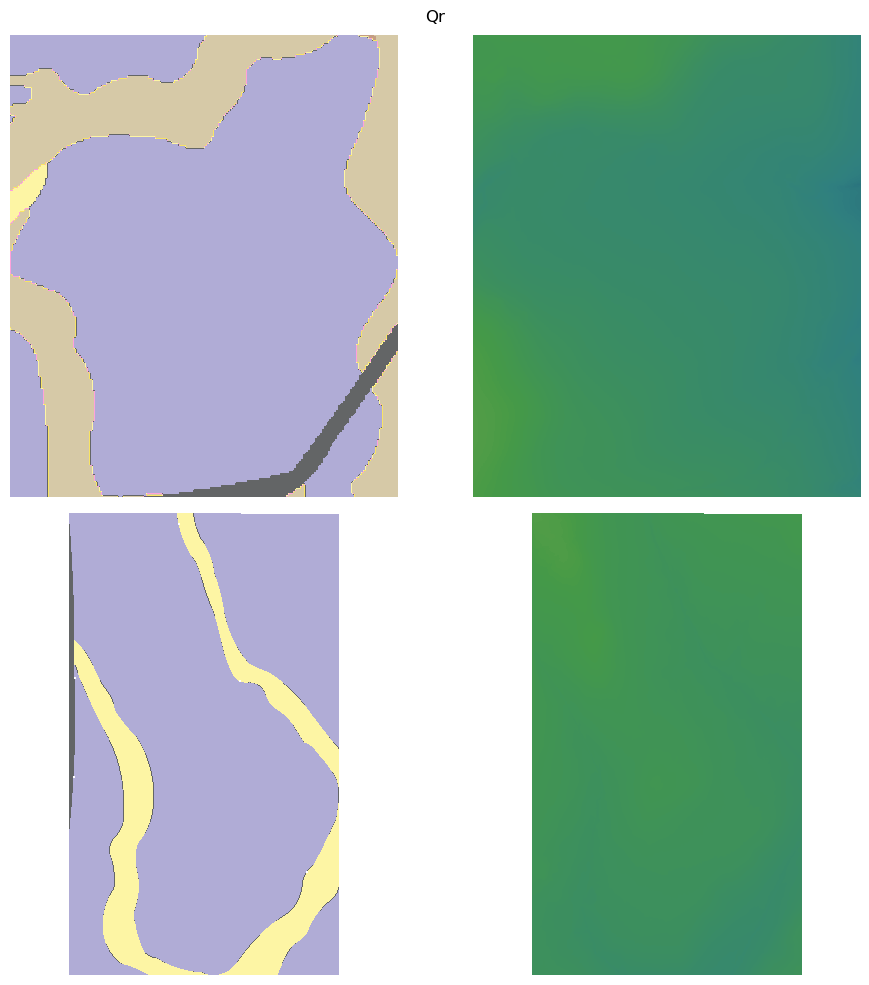

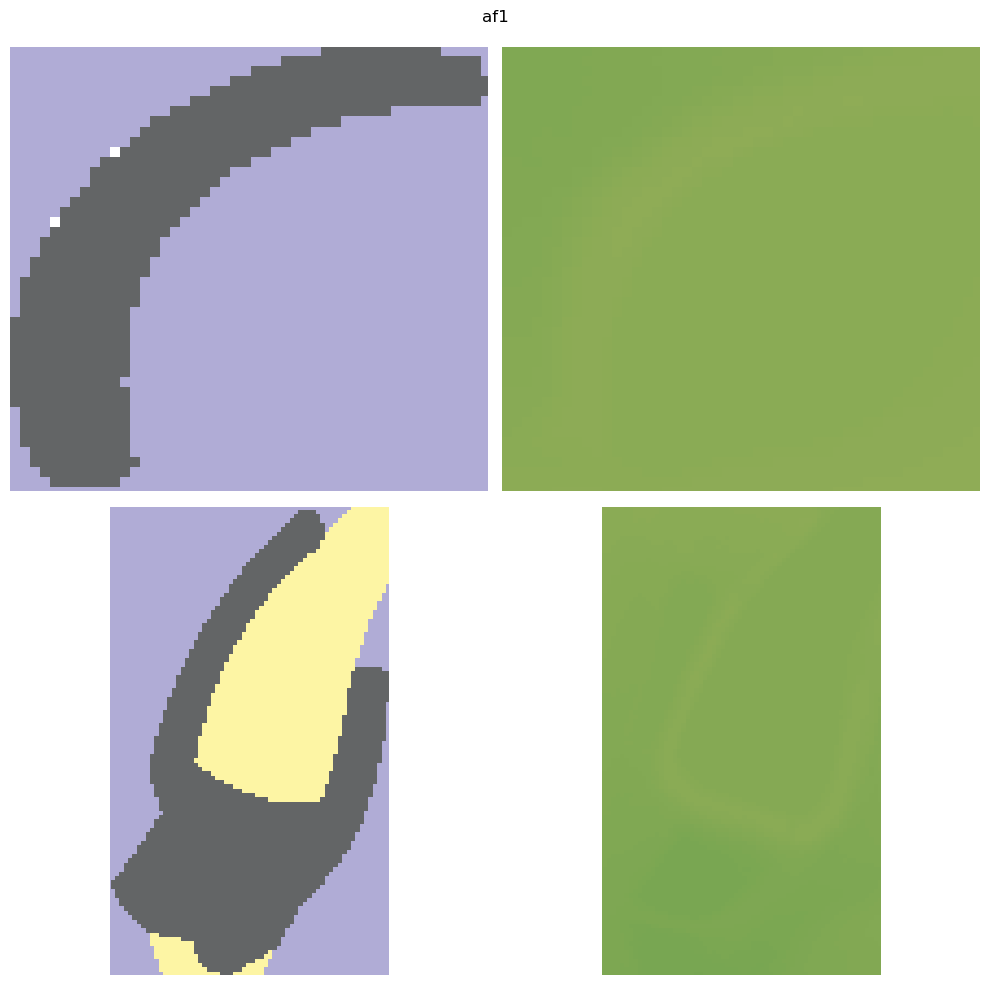

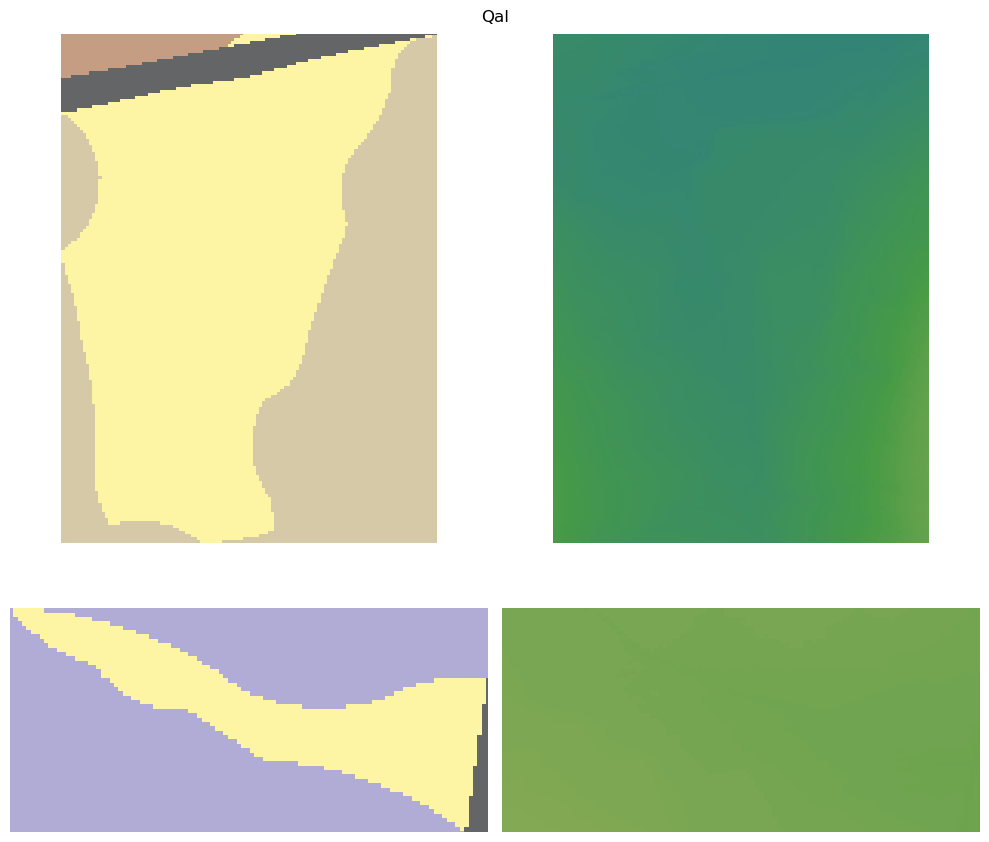

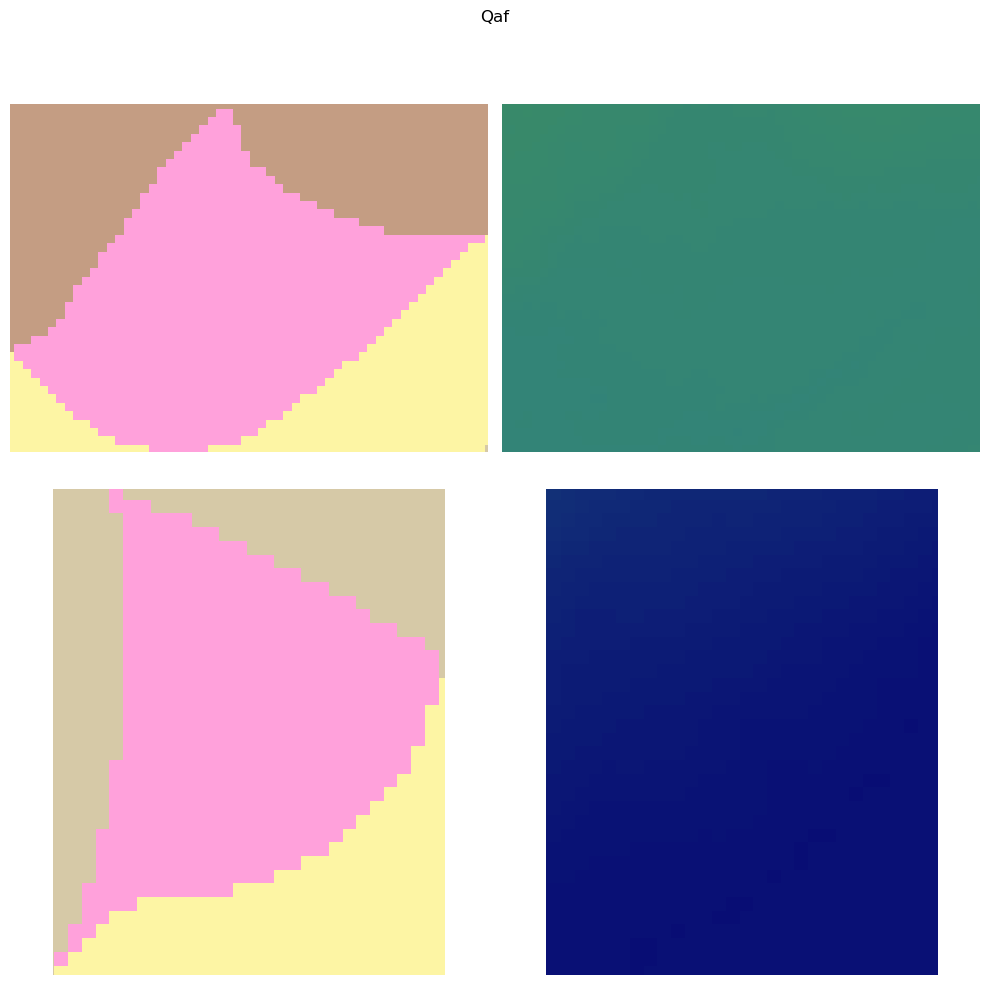

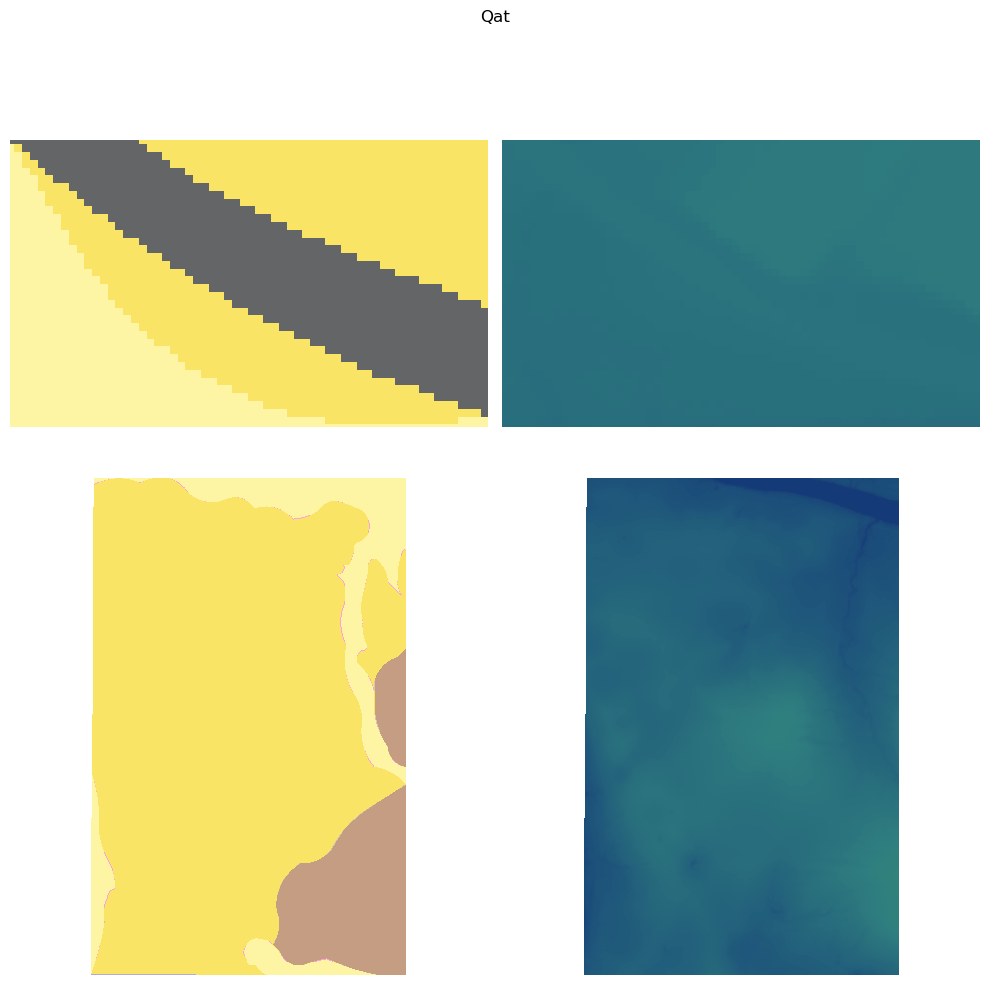

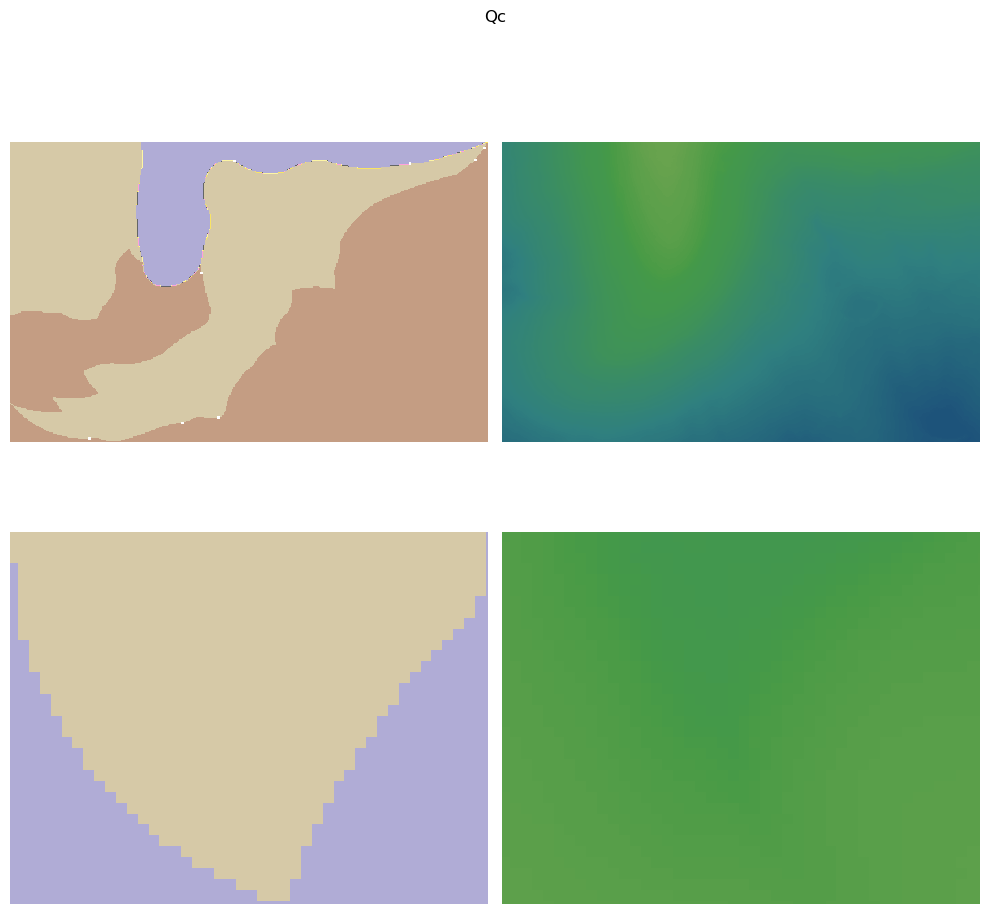

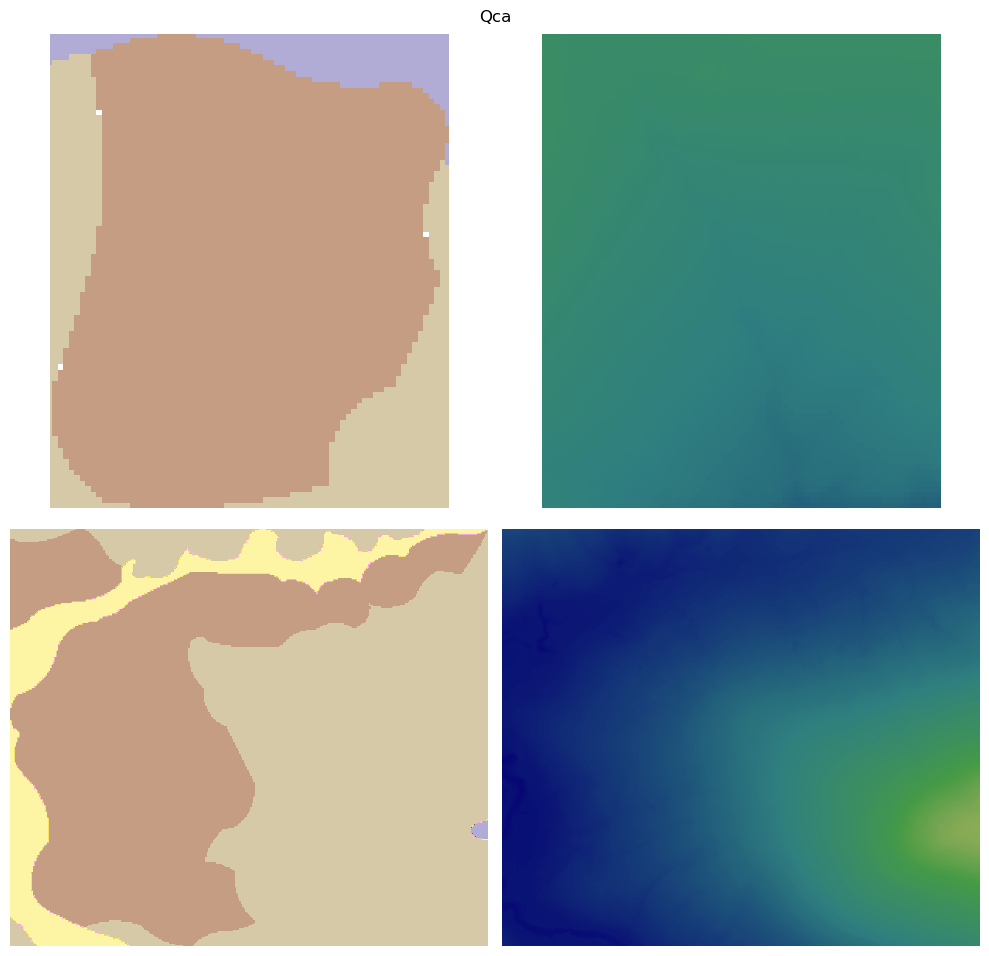

In [74]:
# open geologic map image and plot...
with rasterio.open(warren_geo_path) as geo:

    # read data (mask nodata values)
    geo_data = geo.read(1, masked=True)

    # Get the image extent
    extent = (geo.bounds.left, geo.bounds.right, geo.bounds.bottom, geo.bounds.top)

    
    with rasterio.open(warren_dem_path) as dem:

        dem_data = dem.read(1, masked=True)



    for unit in gdf['Symbol'].unique():

        mask = gdf['Symbol'] == unit

        gdf_subset = gdf.loc[mask].copy()

        gdf_subset.reset_index(drop=True, inplace=True)

        


        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

        ax = ax.ravel()
        
        random_indices = rng.choice(gdf_subset.index, size=2, replace=False)

        ax[0].imshow(geo_data, cmap=cmap, extent=extent)
        polygon_rand1_bbox = gdf_subset.loc[random_indices[0]].geometry.bounds
        ax[0].set_xlim(polygon_rand1_bbox[0], polygon_rand1_bbox[2])
        ax[0].set_ylim(polygon_rand1_bbox[1], polygon_rand1_bbox[3])
        # ax[0].set_title('Randomly Chosen #1', style='italic')


        ax[1].imshow(dem_data, cmap='gist_earth', extent=extent)
        ax[1].set_xlim(polygon_rand1_bbox[0], polygon_rand1_bbox[2])
        ax[1].set_ylim(polygon_rand1_bbox[1], polygon_rand1_bbox[3])


        ax[2].imshow(geo_data, cmap=cmap, extent=extent)
        polygon_rand2_bbox = gdf_subset.loc[random_indices[1]].geometry.bounds
        ax[2].set_xlim(polygon_rand2_bbox[0], polygon_rand2_bbox[2])
        ax[2].set_ylim(polygon_rand2_bbox[1], polygon_rand2_bbox[3])
        # ax[2].set_title('Randomly Chosen #2', style='italic')


        ax[3].imshow(dem_data, cmap='gist_earth', extent=extent)
        ax[3].set_xlim(polygon_rand2_bbox[0], polygon_rand2_bbox[2])
        ax[3].set_ylim(polygon_rand2_bbox[1], polygon_rand2_bbox[3])



        for axis in ax:
            axis.set_axis_off()

        plt.suptitle(f"{unit}")

        plt.tight_layout()
        plt.show()

## Hardin County

### DEM

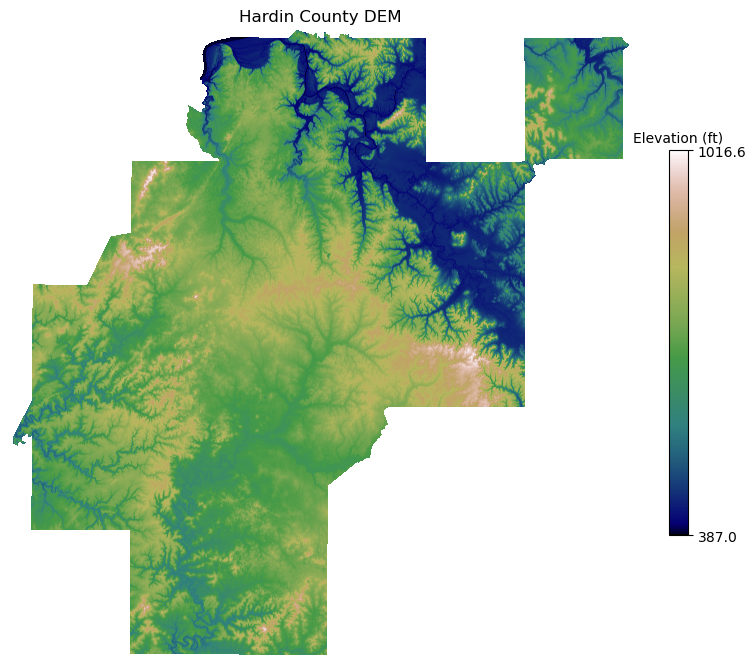

In [14]:
##### Hardin County DEM

with rasterio.open(hardin_dem_path) as dem:

    data = dem.read(1, masked=True)

    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.imshow(data, cmap='gist_earth')
    cbar = fig.colorbar(cax, shrink=0.5, ticks=None)
    cbar.set_ticks(ticks=[np.min(data), np.max(data)])
    cbar.ax.set_title('Elevation (ft)', fontdict={'fontsize':10, 'horizontalalignment':'center'})
    ax.set_axis_off()
    ax.set_title('Hardin County DEM')
    plt.show()

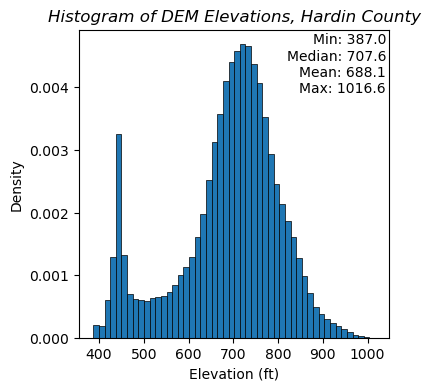

In [34]:
##### Hardin County DEM Histogram

plot_dem_histogram(hardin_dem_path, 'Histogram of DEM Elevations, Hardin County')

In [ ]:
##### Aggregated statistics of Geologic Map Unit by Area

input_shapefile_path = r'../data/warren/geo_warren.shp'

gdf = gpd.read_file(input_shapefile_path)

gdf['area'] = gdf['geometry'].area

gdf.groupby('Symbol')['area'].agg(['min', 'mean', 'max', 'sum'])

In [ ]:
##### plot histograms of DEM...

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plt.subplots_adjust(wspace=0.3)

with rasterio.open(warren_dem_path) as dem:

    all_data = dem.read(1)
    masked_data = dem.read(1, masked=True)
    
    ax[0].hist(all_data.flatten(), density=True)
    ax[0].set_title('All Data')
    ax[1].hist(masked_data.flatten(), density=True)
    ax[1].set_title('Valid Data (no-data masked)')

    for idx in range(len(ax)):
        ax[idx].set_xlabel('Elevation (feet)')
        ax[idx].set_ylabel('Density')

    plt.suptitle('Warren County DEM')
    plt.show()

In [ ]:
##### Plot Class Distributions of Geologic Map

with rasterio.open(warren_geo_path) as geo:
    
    labels = geo.read(1)

    unique_labels, counts = np.unique(labels, return_counts=True)

    class_distribution = dict(zip(unique_labels, counts))

    plt.bar(x=range(len(class_distribution)), 
            height=list(class_distribution.values()), 
            tick_label=list(class_distribution.keys()), 
            align='center')

    plt.title('Warren County Geologic Label Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count (pixels)')
    plt.show()

### Surficial Geologic Map

In [42]:
##### Keep only 7 Geologic Units from Warren County

# open warren county json metadata
with open(warren_geo_meta, 'r') as warren_meta:
    warren_geo_labels = json.load(warren_meta)



# open hardin county json metadata
with open(hardin_geo_meta, 'r') as hardin_meta:
    hardin_geo_labels = json.load(hardin_meta)



hardin_integers_mask = list(hardin_geo_labels.values())

for warren_label in warren_geo_labels.keys():

    hardin_integers_mask.remove(hardin_geo_labels[warren_label])



with rasterio.open(hardin_geo_path) as geo:

    data = geo.read(1)
    nodata_value = geo.nodata
    meta = geo.meta

    for integer in hardin_integers_mask:

        data[data == integer] = nodata_value

    hardin_geo_mask_path = r'../data/hardin/geo_hardin_mask.tif'

    with rasterio.open(hardin_geo_mask_path, 'w', **meta) as dst:

        dst.write(data, 1)

In [68]:
##### Warren County Integer-to-Symbol Encoding/Decoding

# open json metadata for map unit to integer mapping
with open(hardin_geo_meta, 'r') as geo_meta:
    geo_labels = json.load(geo_meta)

# custom rgb colors for warren county map units
geo_labels_rgb = {'Qr':(176,172,214), 
                  'af1':(99,101,102), 
                  'Qal':(253,245,164), 
                  'Qaf':(255,161,219), 
                  'Qat':(249,228,101), 
                  'Qc':(214,201,167), 
                  'Qca':(196,157,131)}

# reverse mapping as integer (key) to map unit (value)
geo_ints = {geo_labels[key]:key for key in geo_labels_rgb.keys()}



# reverse color mapping to integer and rgb percentage (rgb/255)
geo_ints_colors = {geo_labels[key]:tuple(v/255 for v in value) for key, value in geo_labels_rgb.items()}

# create custom color map
cmap = plt.matplotlib.colors.ListedColormap([geo_ints_colors[key] for key in geo_ints.keys()])

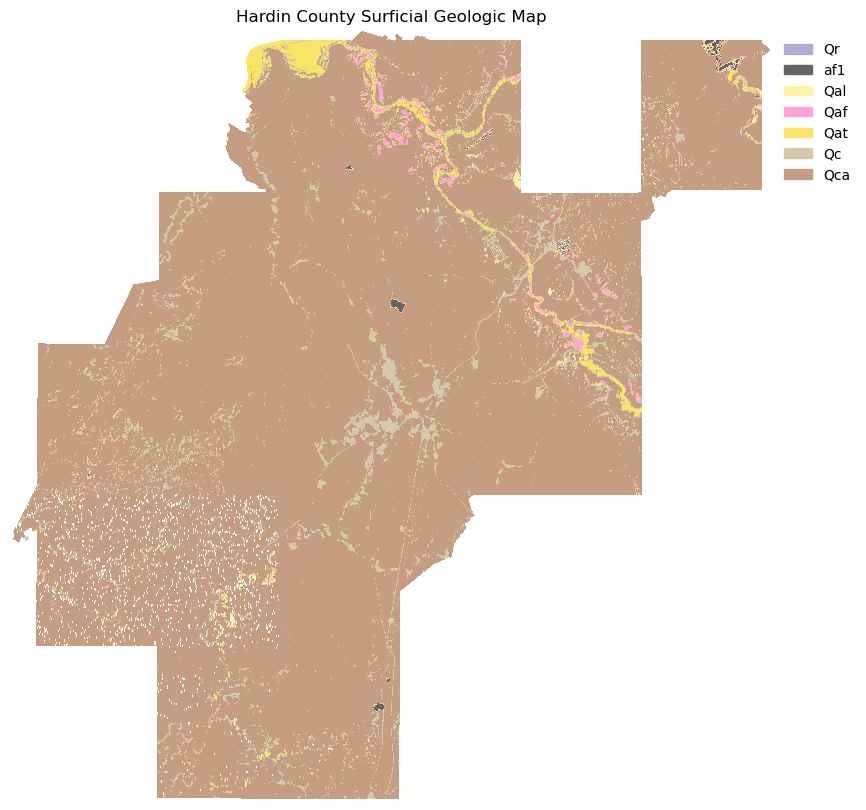

In [75]:
##### Hardin County Geologic Map

# open geologic map image and plot...
with rasterio.open(hardin_geo_path) as geo:

    # read data (mask nodata values)
    data = geo.read(1, masked=True)

    # plot image...
    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.imshow(data, cmap=cmap)

    # create custom legend items
    handles = [mpatches.Patch(color=geo_ints_colors[key], label=geo_ints[key]) for key in geo_ints.keys()]
    ax.legend(handles=handles, bbox_to_anchor=(1,1), loc='upper left', frameon=False)

    # adjust plot elements
    ax.set_axis_off()
    ax.set_title('Hardin County Surficial Geologic Map')
    plt.show()

In [79]:
input_shapefile_path = r'../data/hardin/geo_hardin.shp'

gdf = gpd.read_file(input_shapefile_path)

gdf['area'] = gdf['geometry'].area

for unit in gdf['Symbol'].unique():
    print(unit)
    print('Minimum Area (sq. ft.): ', round(gdf.loc[gdf['Symbol']==unit, 'area'].min(), 2))
    print('Mean Area (sq. ft.): ', round(gdf.loc[gdf['Symbol']==unit, 'area'].mean(), 2))
    print('Maximum Area (sq. ft.): ', round(gdf.loc[gdf['Symbol']==unit, 'area'].max(), 2))
    print('\n')

Qot2
Minimum Area (sq. ft.):  5954.62
Mean Area (sq. ft.):  42242.99
Maximum Area (sq. ft.):  244780.92


Qapc
Minimum Area (sq. ft.):  34055.33
Mean Area (sq. ft.):  330395.24
Maximum Area (sq. ft.):  1432015.67


Qha
Minimum Area (sq. ft.):  10434.11
Mean Area (sq. ft.):  1476830.95
Maximum Area (sq. ft.):  4599906.52


Qalo
Minimum Area (sq. ft.):  29653.37
Mean Area (sq. ft.):  634723.68
Maximum Area (sq. ft.):  1706748.99


af2
Minimum Area (sq. ft.):  349240.63
Mean Area (sq. ft.):  3895266.34
Maximum Area (sq. ft.):  10373973.67


Qlt
Minimum Area (sq. ft.):  11426.77
Mean Area (sq. ft.):  1182532.03
Maximum Area (sq. ft.):  6065096.22


Qls
Minimum Area (sq. ft.):  5424.65
Mean Area (sq. ft.):  63323.87
Maximum Area (sq. ft.):  650303.0


PZ
Minimum Area (sq. ft.):  9387.27
Mean Area (sq. ft.):  60769.68
Maximum Area (sq. ft.):  1737693.91


Qat3
Minimum Area (sq. ft.):  10632.54
Mean Area (sq. ft.):  571997.05
Maximum Area (sq. ft.):  9027750.63


Qaf
Minimum Area (sq. ft.):  

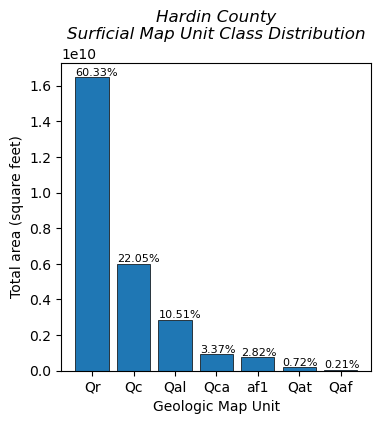

In [80]:
##### Hardin County Geologic Map Unit Class Distribution

fig, ax = plt.subplots(figsize=(4,4))

with rasterio.open(hardin_geo_mask_path) as geo:

    data = geo.read(1, masked=True).compressed()
    x_res, y_res = geo.res

    int_labels, pixel_counts = np.unique(data, return_counts=True)

    int_counts = dict(zip(int_labels, pixel_counts))

    label_areas = {geo_ints[key]:int_counts[key]*x_res*y_res for key in int_counts.keys()}

    label_areas = dict(sorted(label_areas.items(), key=lambda item: item[1], reverse=True))

    x = range(1, len(label_areas)+1)
    areas = list(label_areas.values())
    percentages = [x/sum(label_areas.values())*100 for x in label_areas.values()]
    tick_labels = [x for x in label_areas.keys()]

    bars = ax.bar(x=x, height=areas, tick_label=tick_labels, align='center', linewidth=0.5, edgecolor='k')


    for bar, per in zip(bars, percentages):
        yval = bar.get_height()
        ax.text(x=bar.get_x(), y=yval+float(0.08e9), s=str(round(per, 2))+'%', fontsize=8)


    ax.set_xlabel('Geologic Map Unit')
    ax.set_ylabel('Total area (square feet)')
    ax.set_title('Hardin County\nSurficial Map Unit Class Distribution', style='italic')

    plt.show()

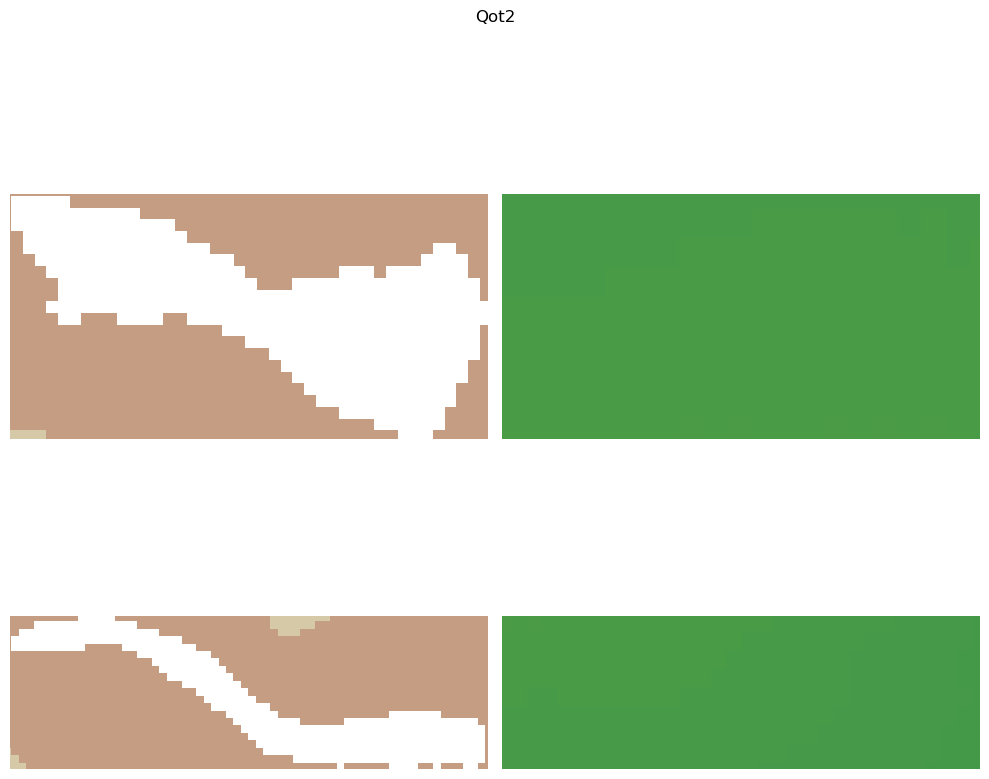

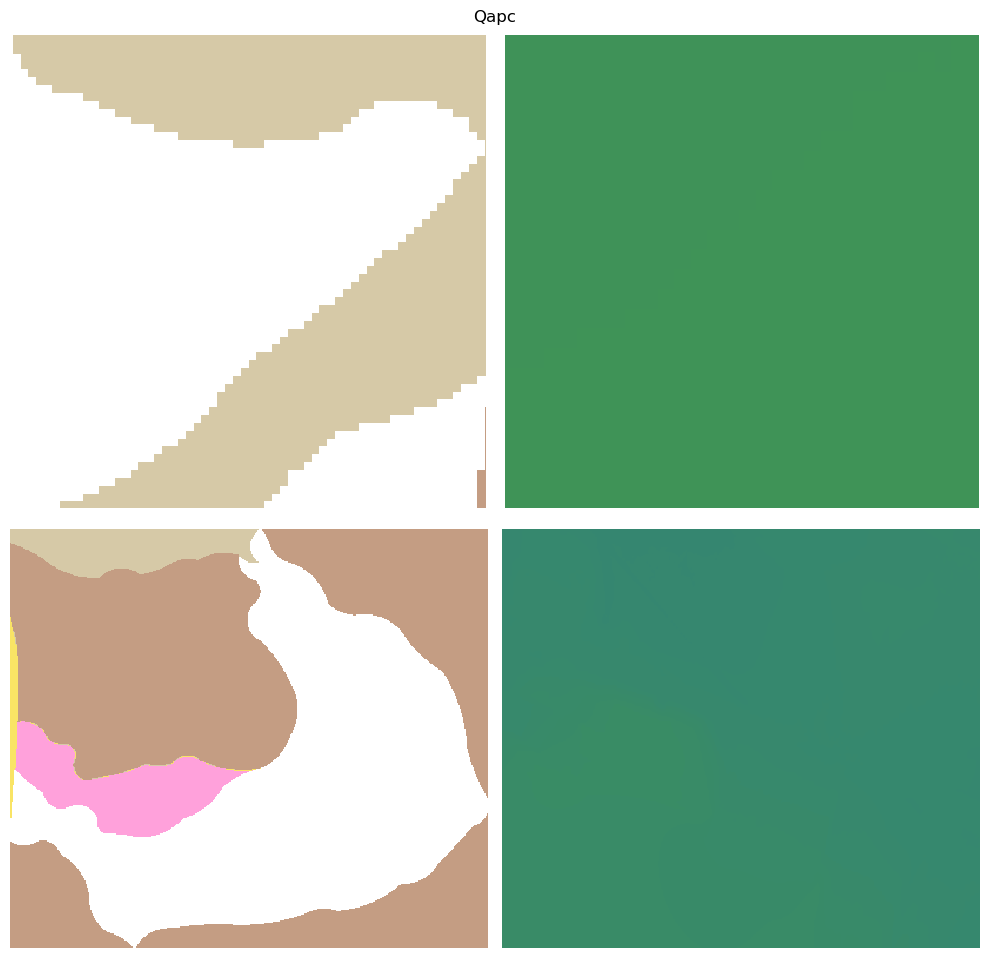

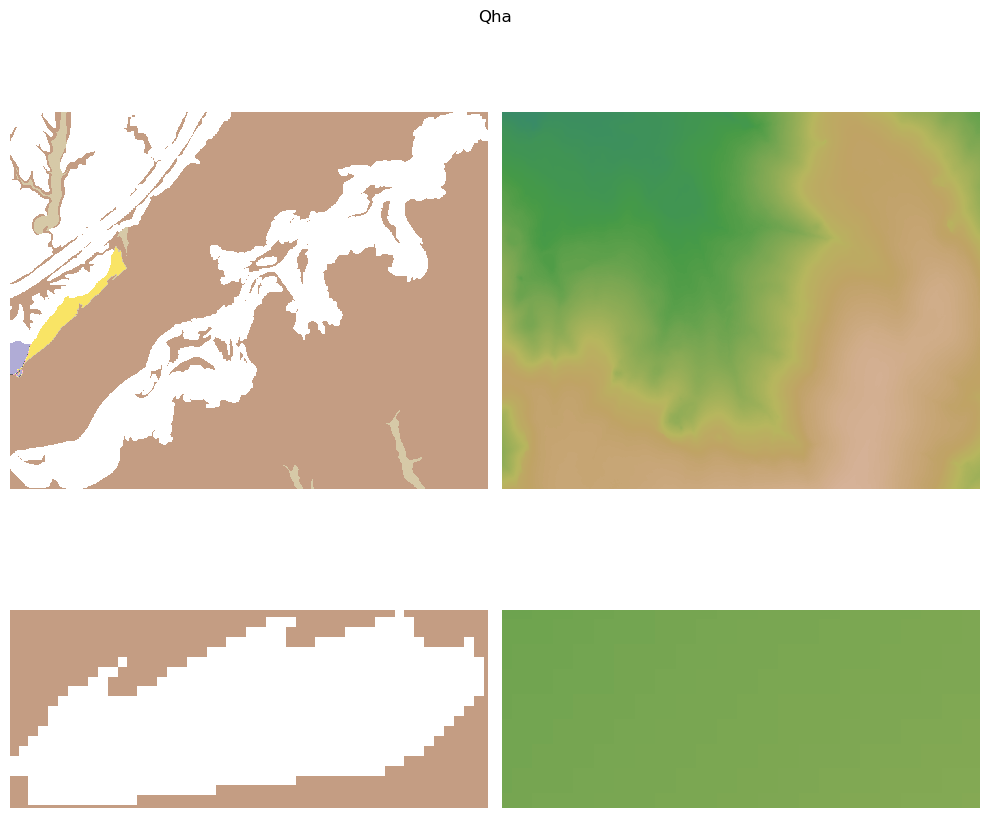

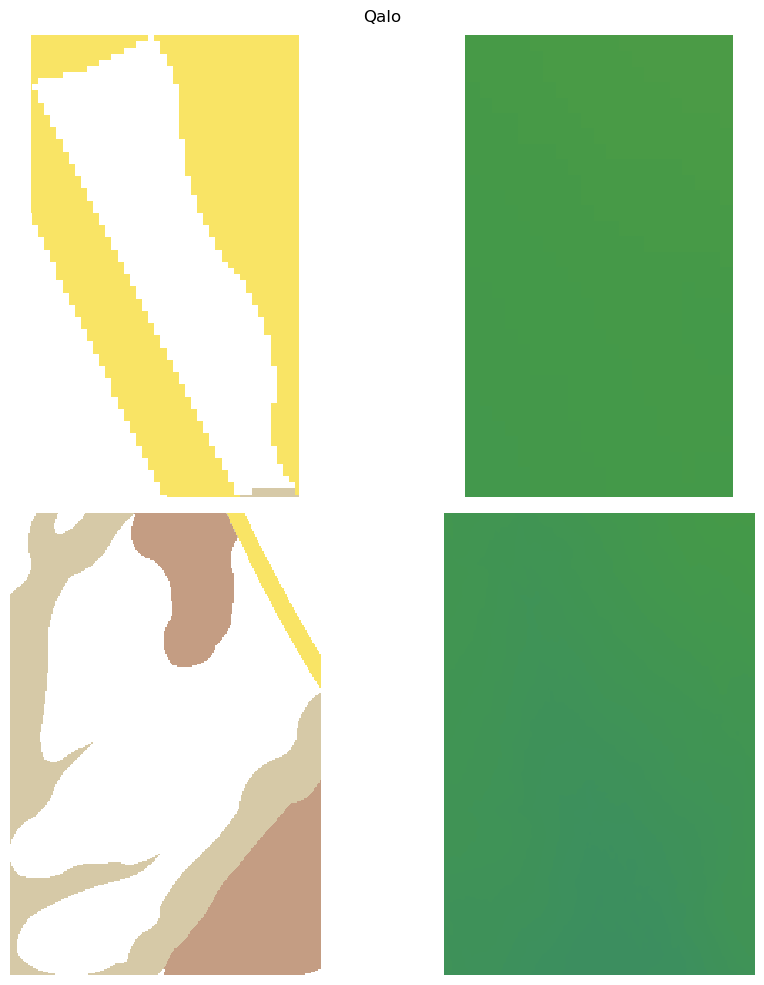

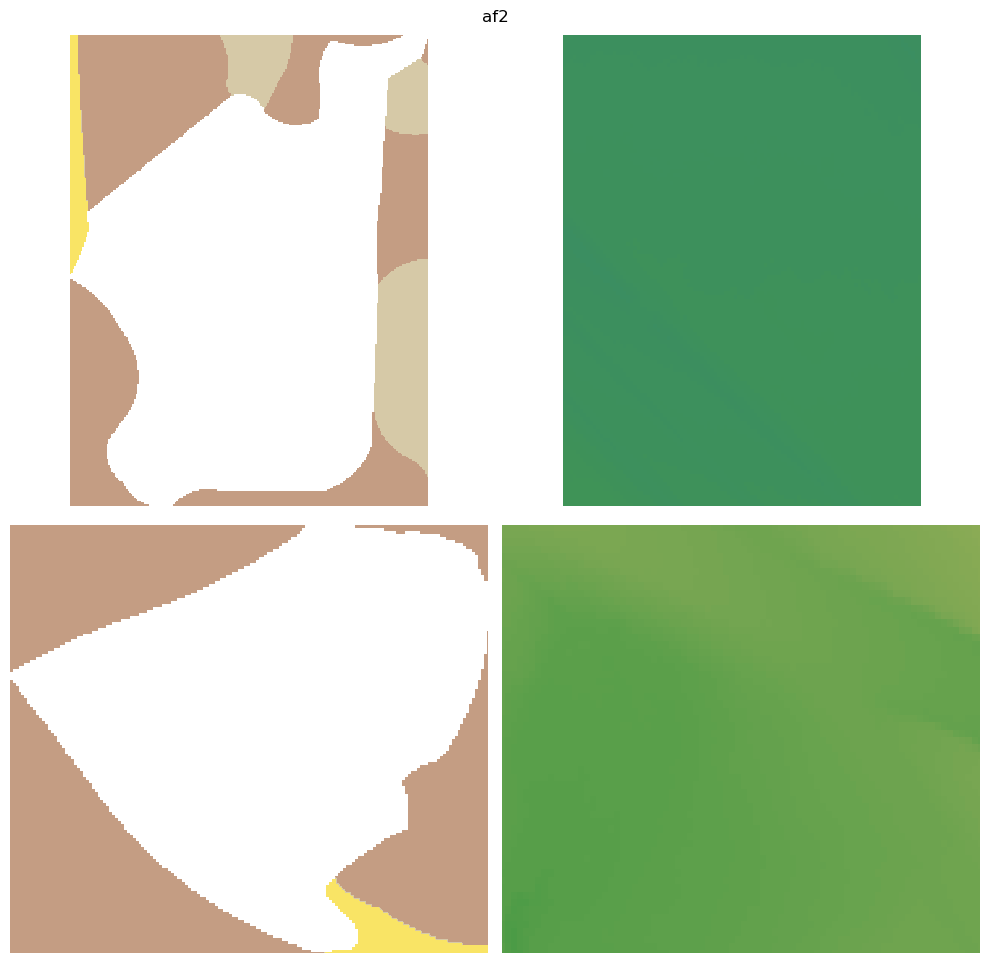

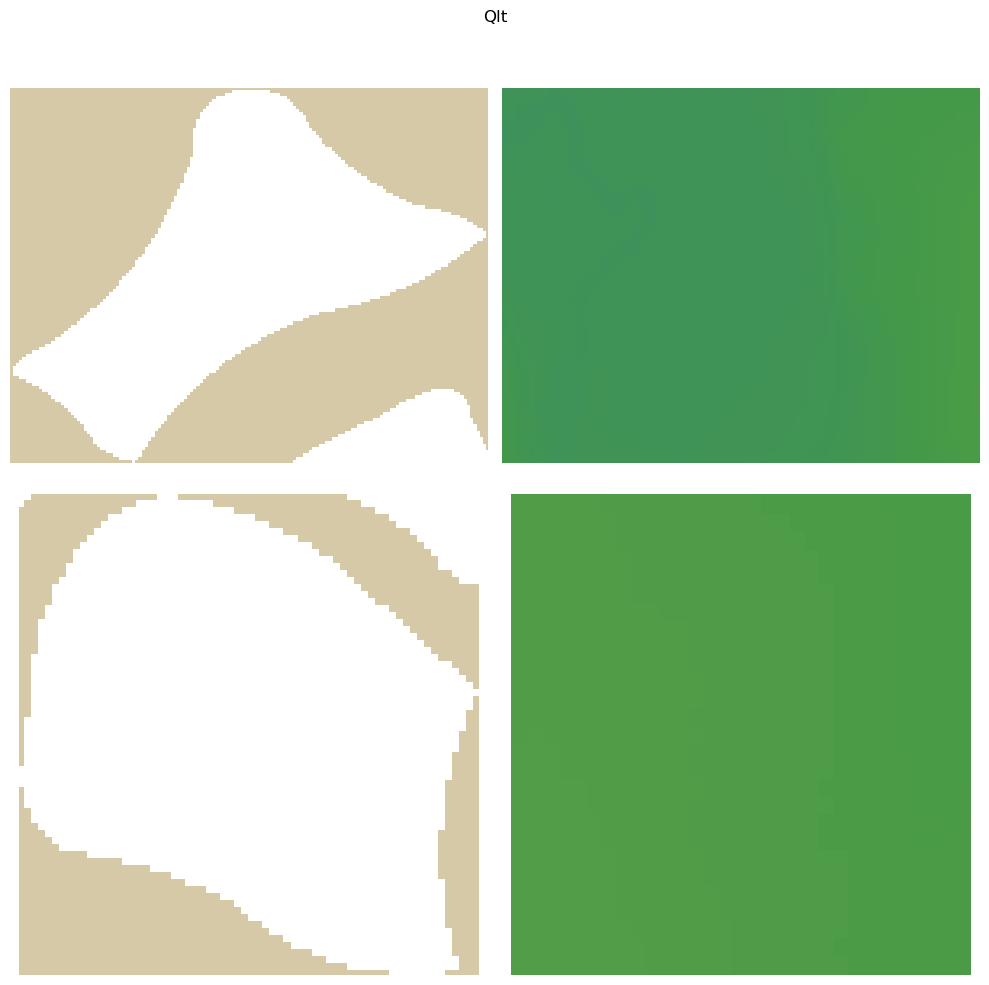

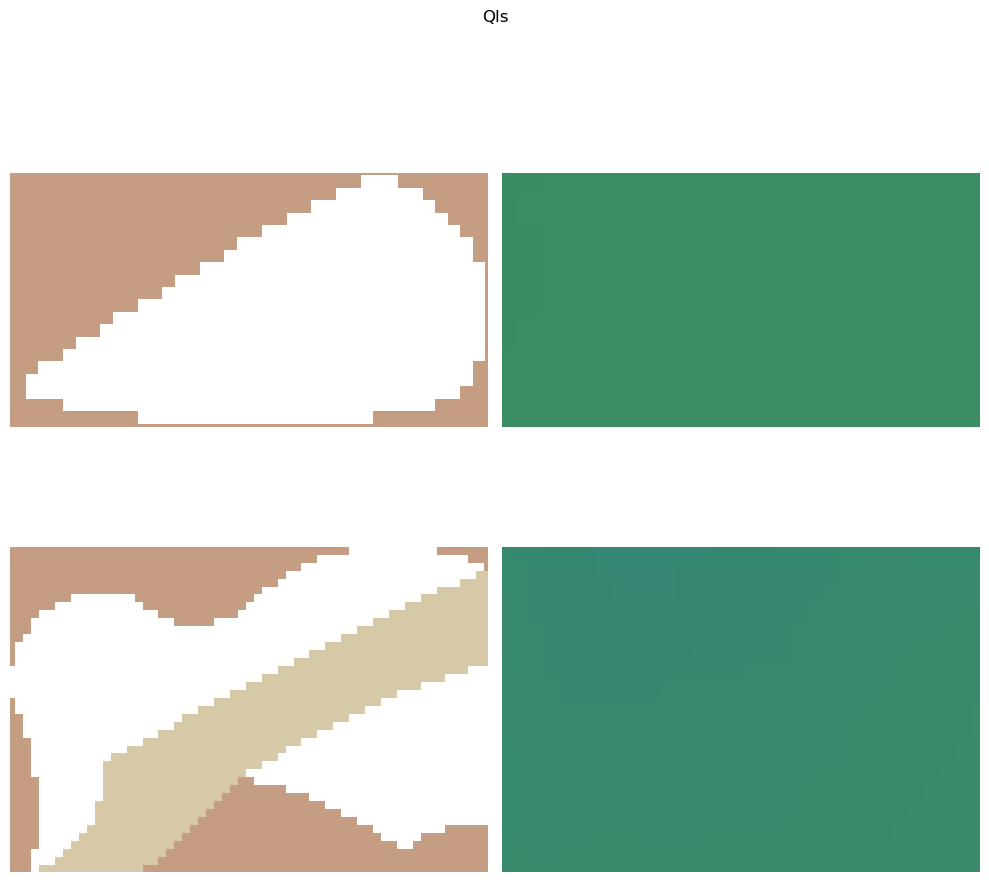

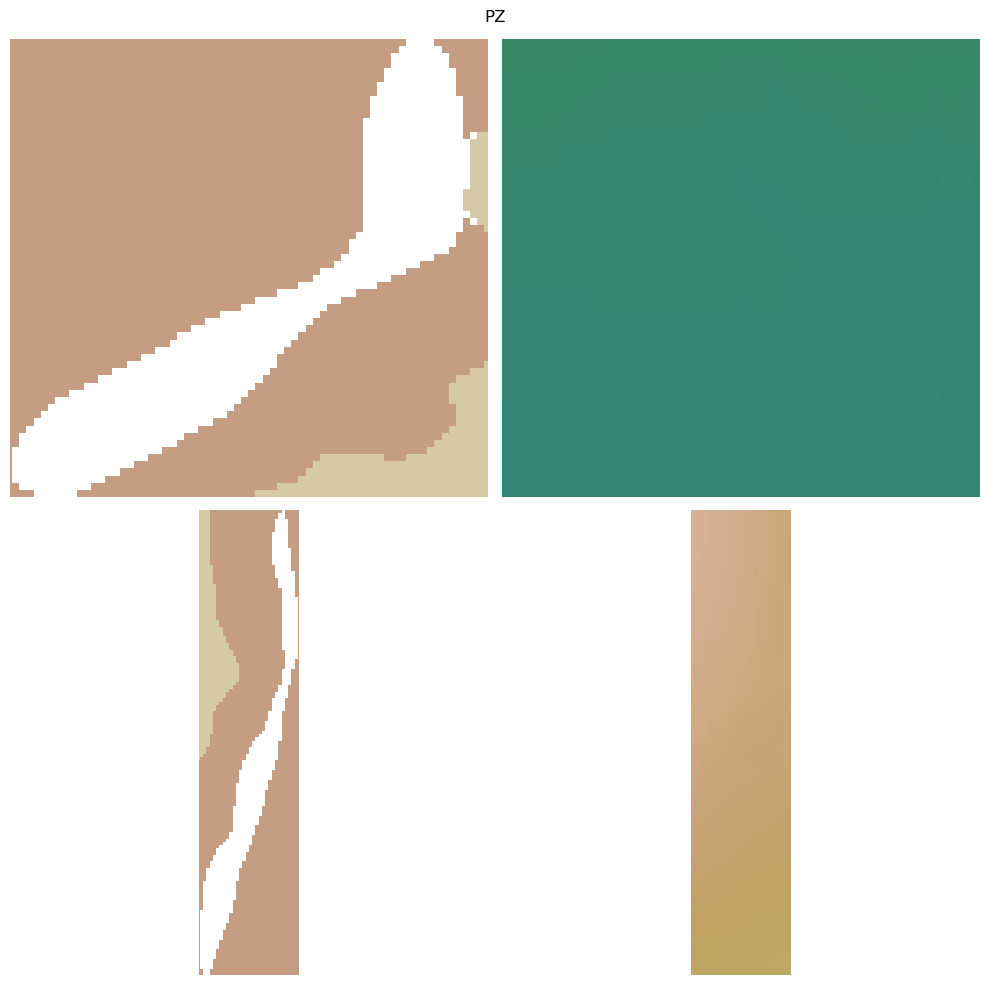

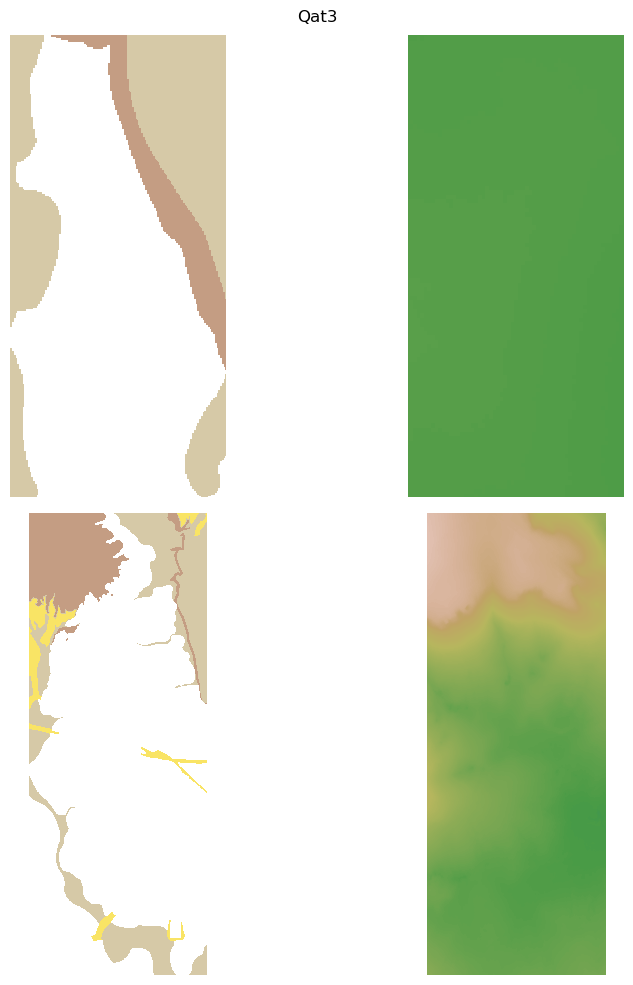

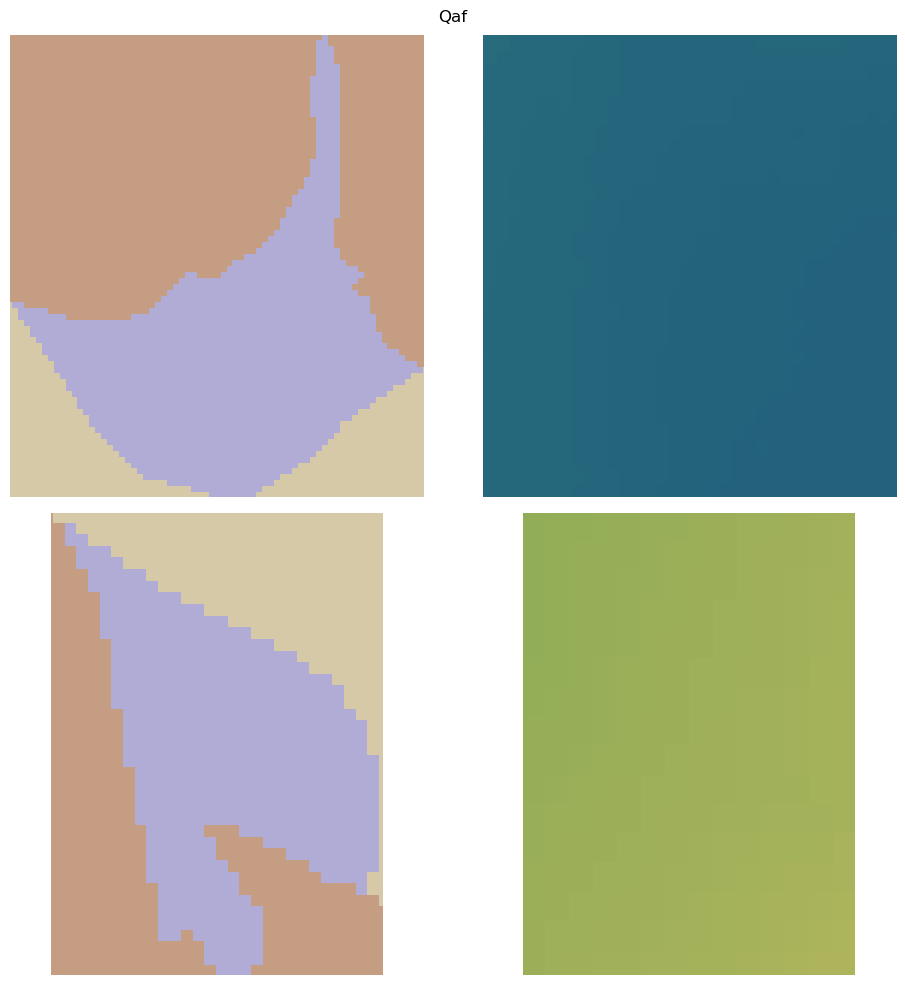

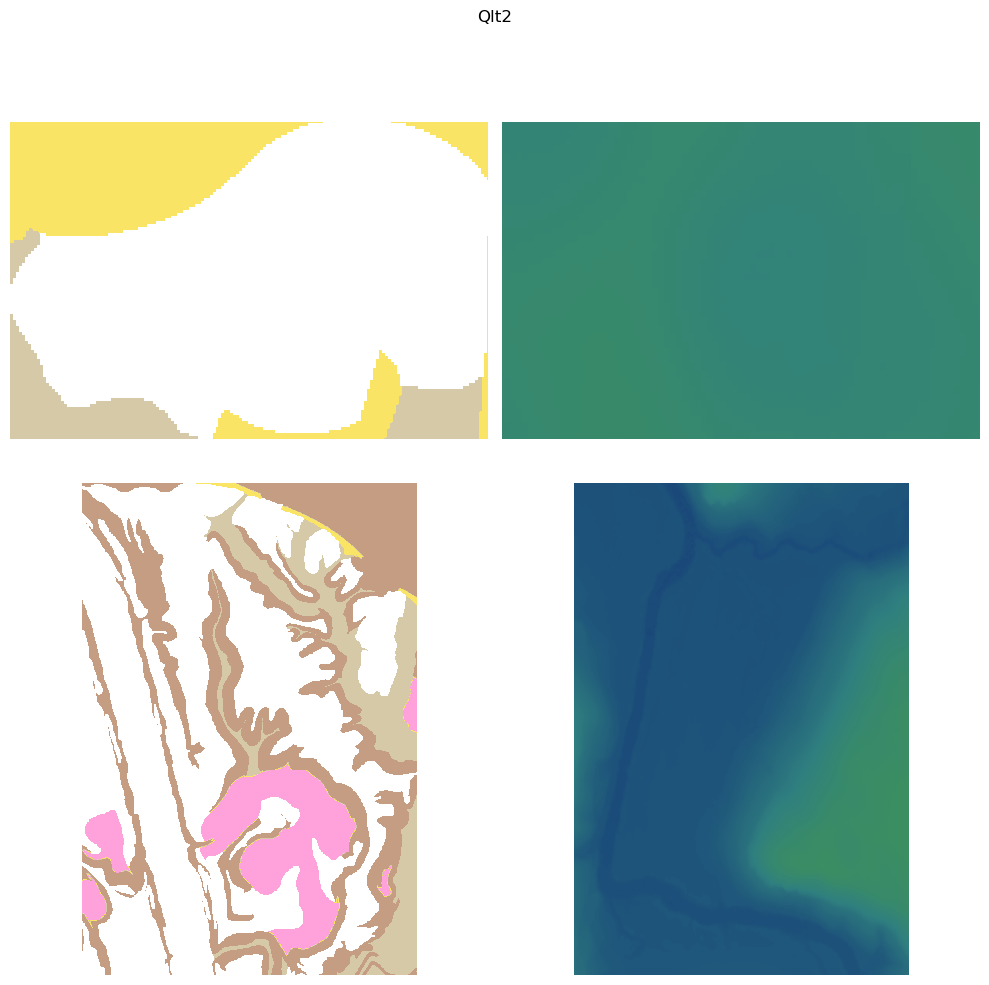

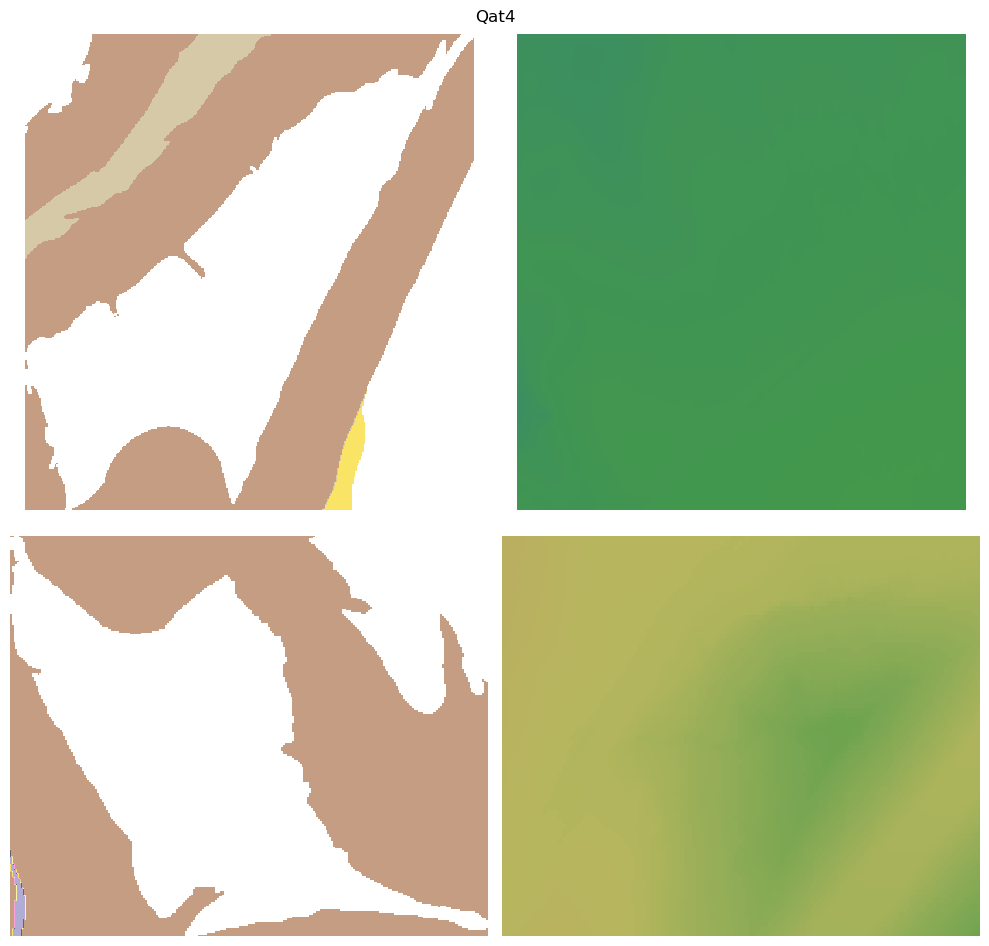

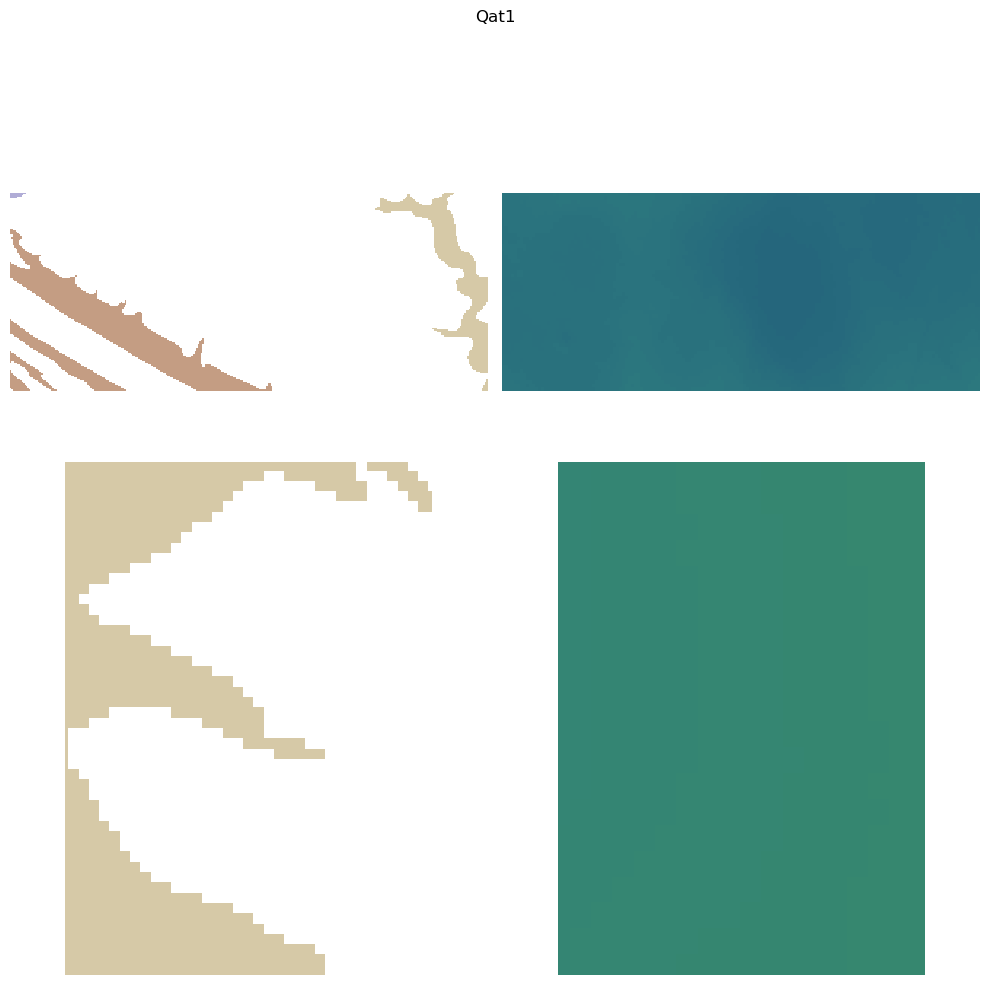

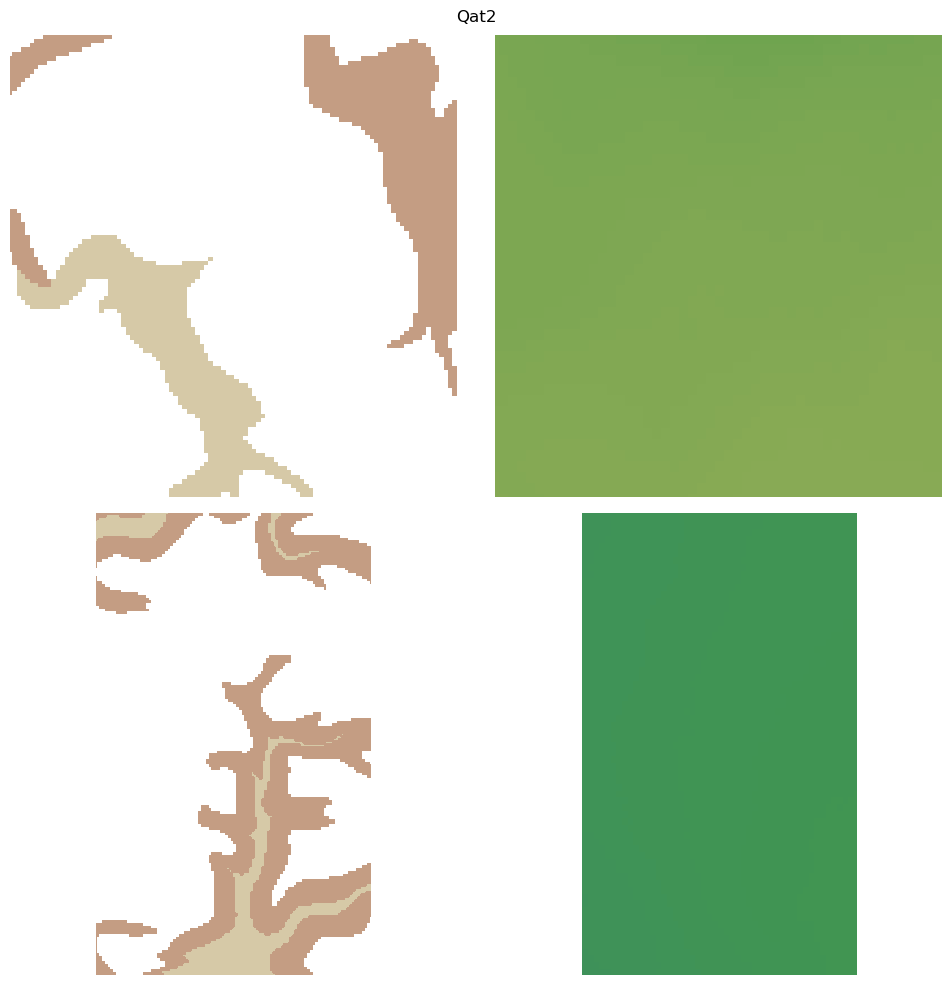

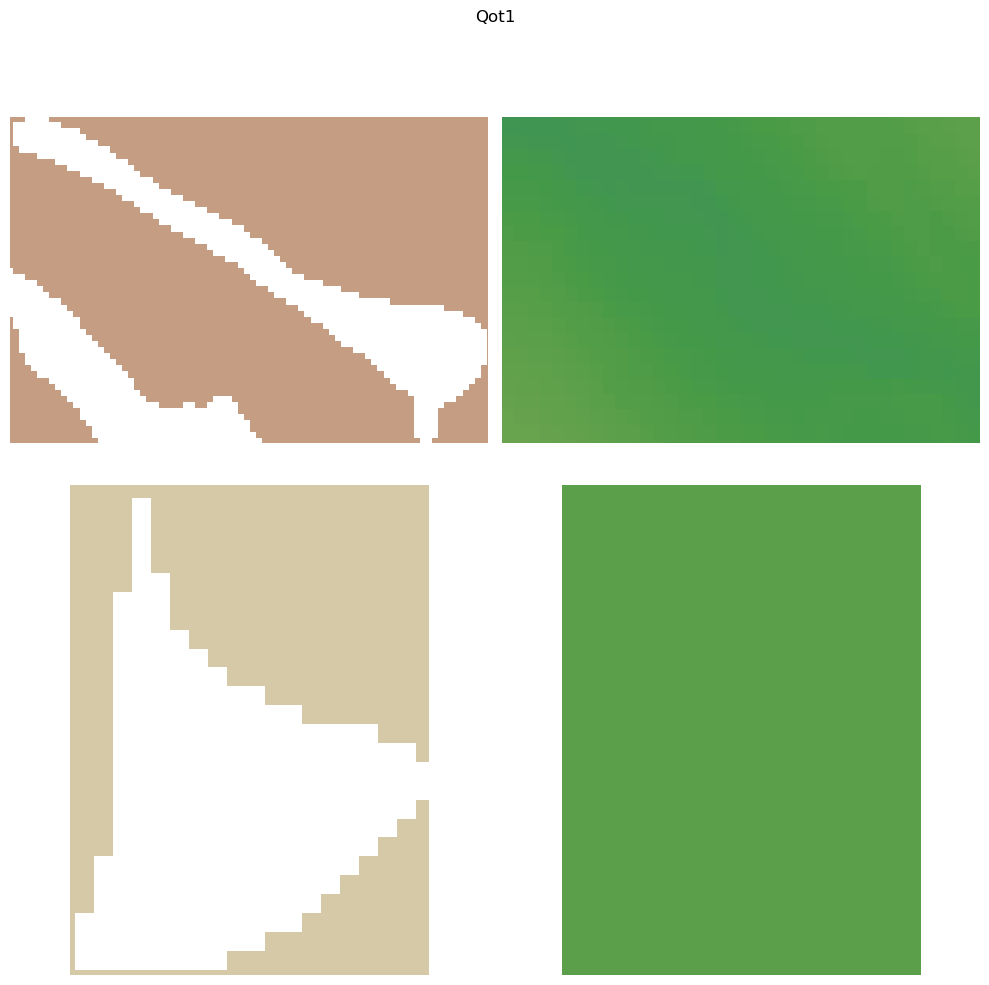

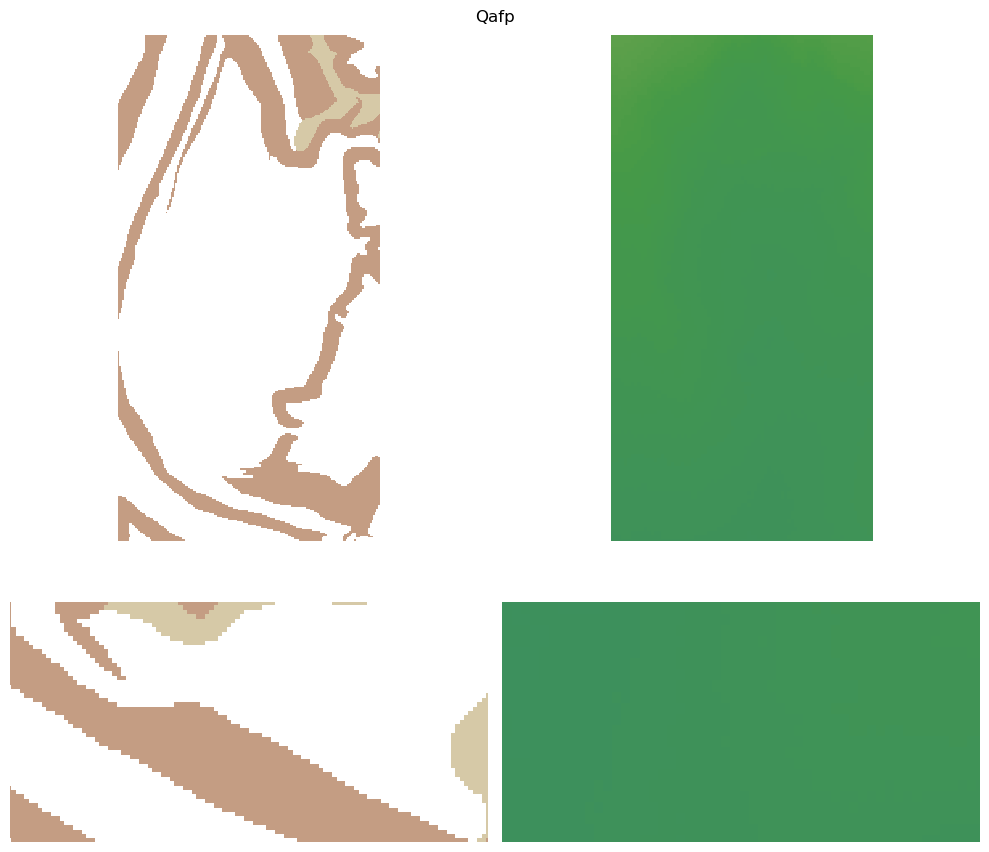

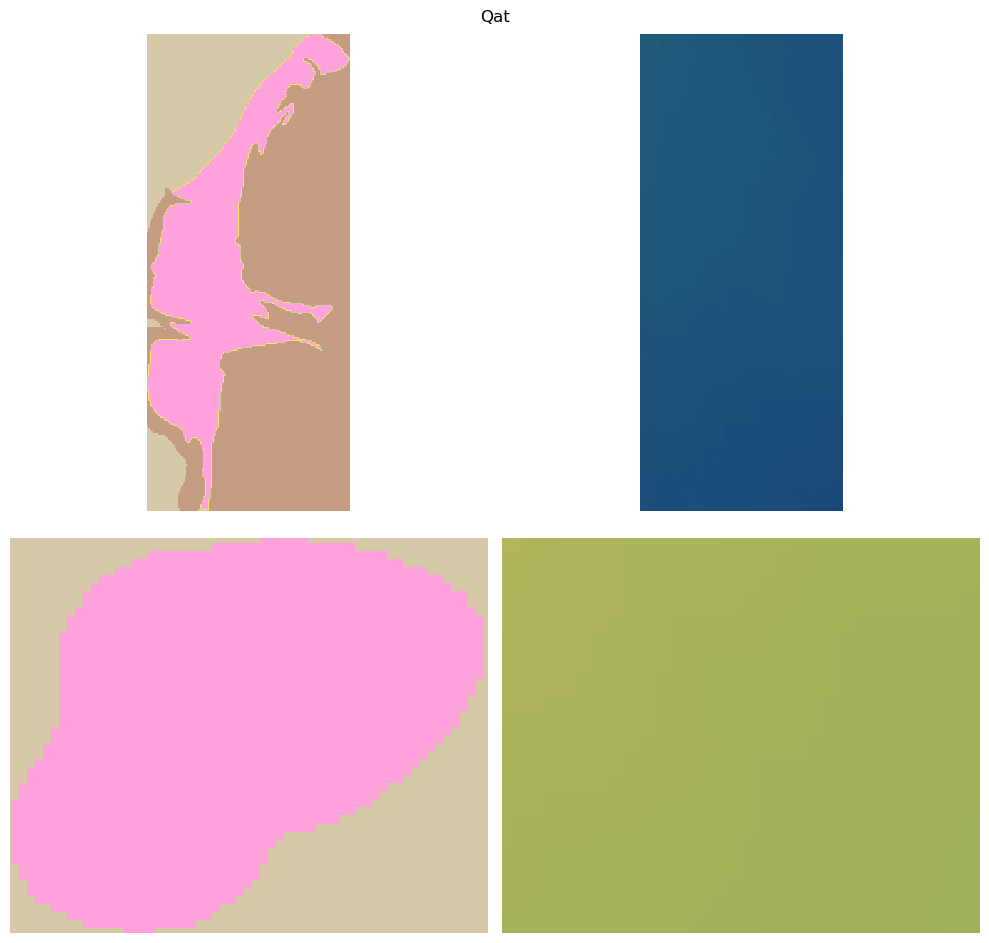

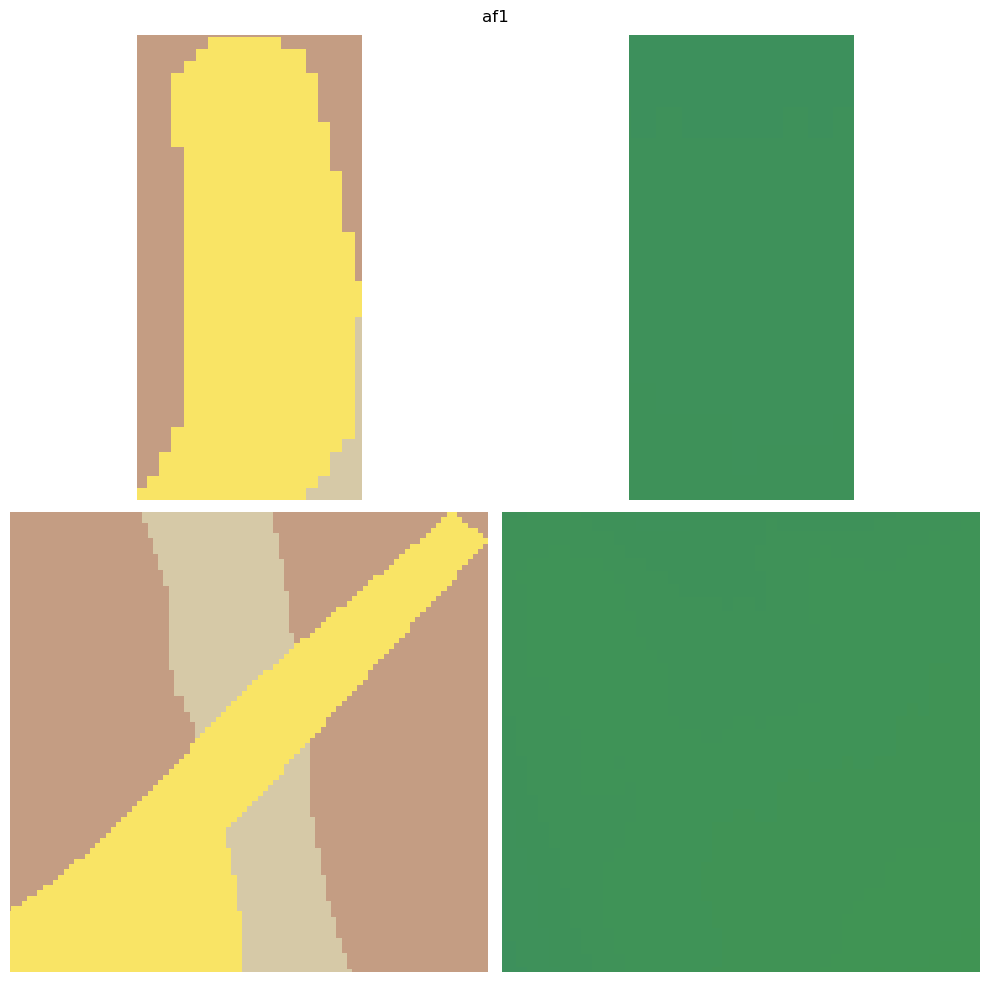

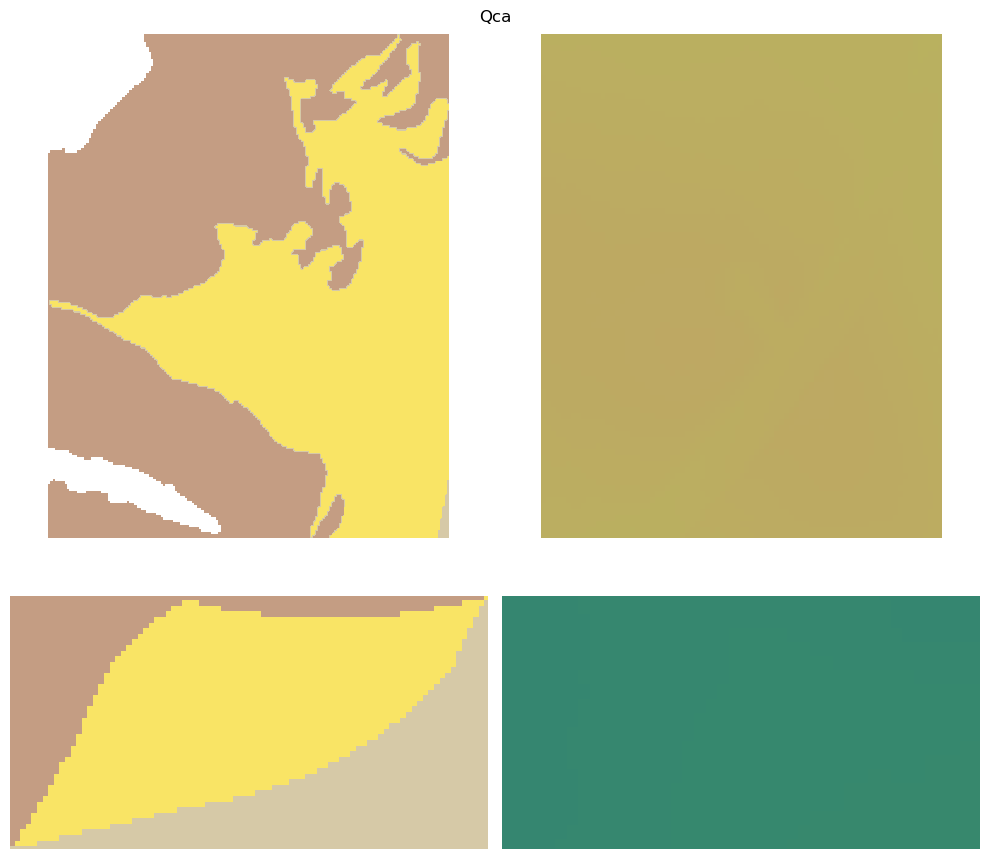

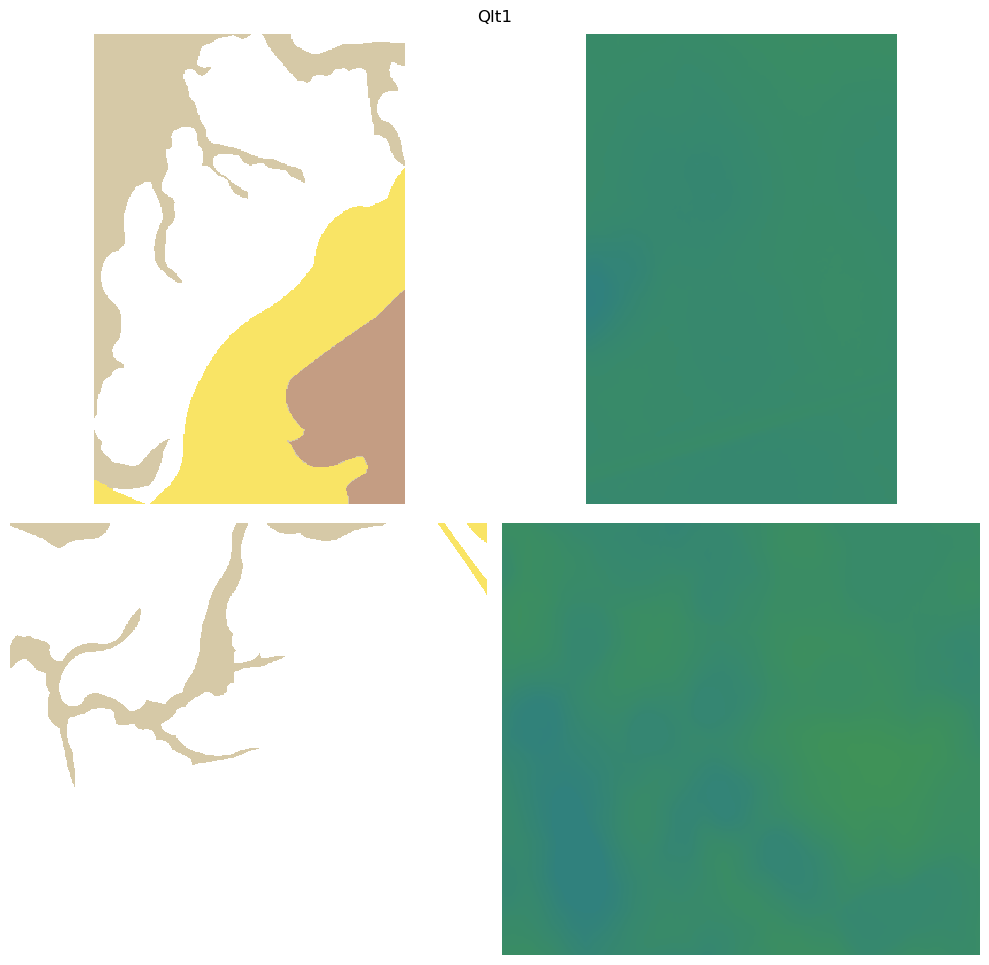

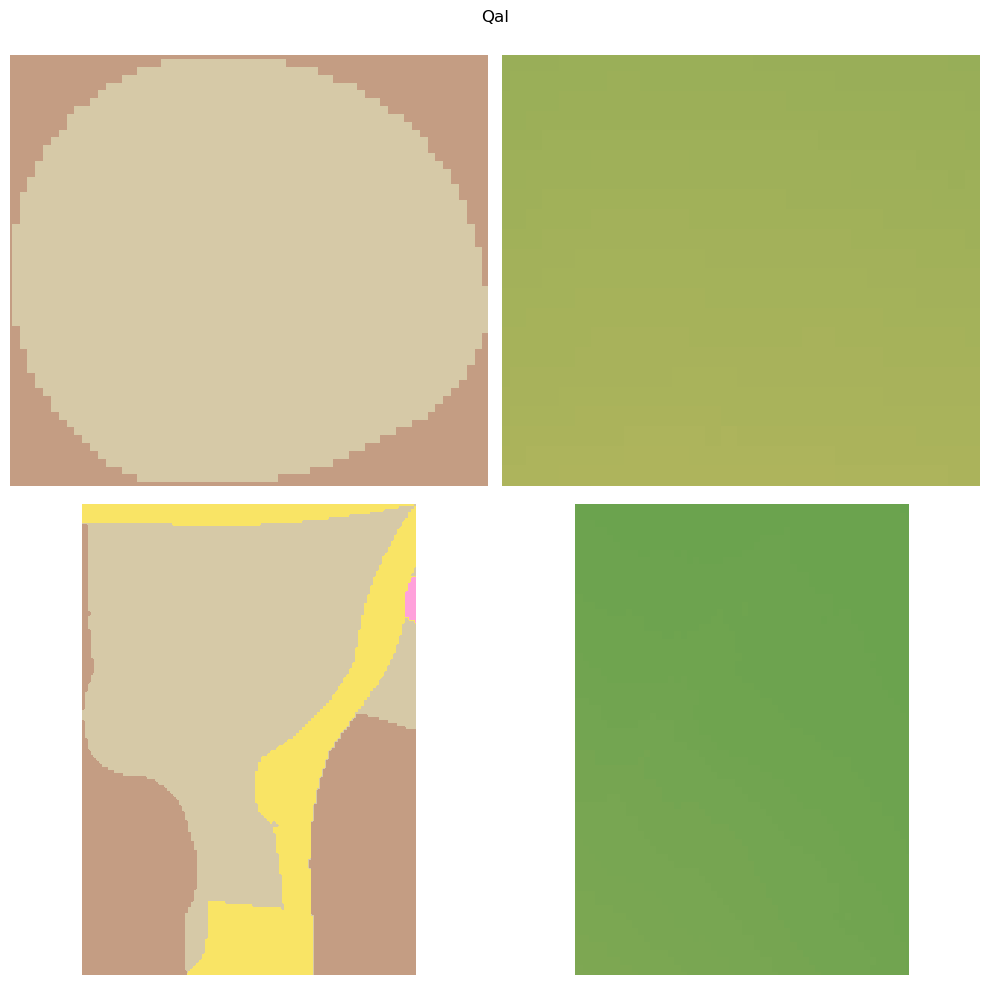

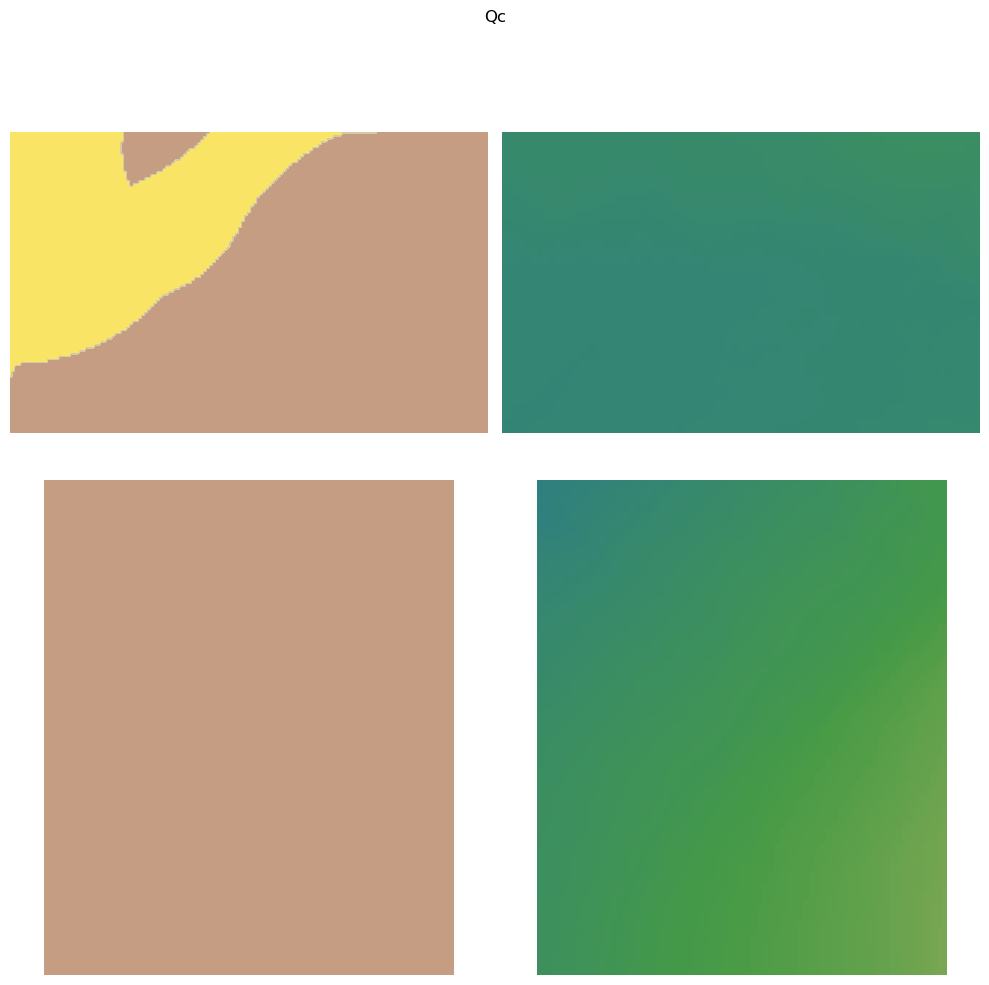

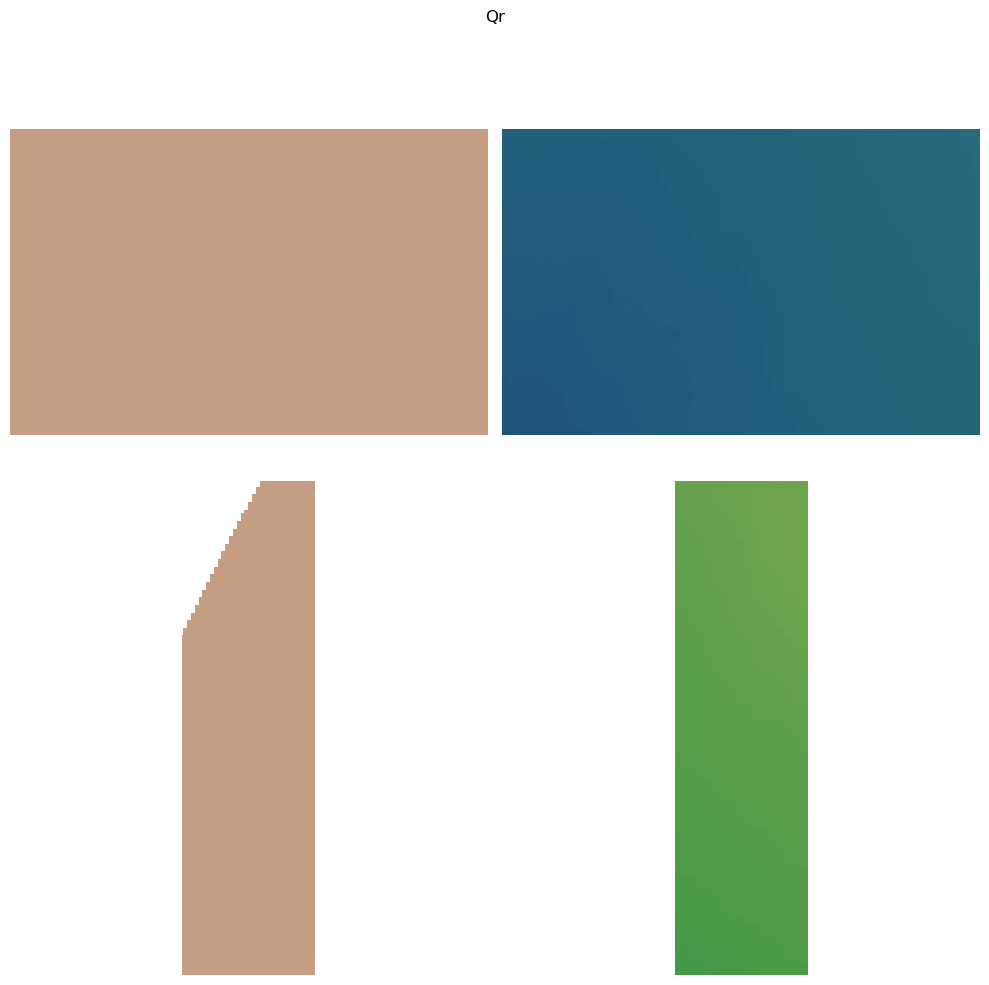

In [81]:
# open geologic map image and plot...
with rasterio.open(hardin_geo_mask_path) as geo:

    # read data (mask nodata values)
    geo_data = geo.read(1, masked=True)

    # Get the image extent
    extent = (geo.bounds.left, geo.bounds.right, geo.bounds.bottom, geo.bounds.top)

    
    with rasterio.open(warren_dem_path) as dem:

        dem_data = dem.read(1, masked=True)



    for unit in gdf['Symbol'].unique():

        mask = gdf['Symbol'] == unit

        gdf_subset = gdf.loc[mask].copy()

        gdf_subset.reset_index(drop=True, inplace=True)

        


        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

        ax = ax.ravel()
        
        random_indices = rng.choice(gdf_subset.index, size=2, replace=False)

        ax[0].imshow(geo_data, cmap=cmap, extent=extent)
        polygon_rand1_bbox = gdf_subset.loc[random_indices[0]].geometry.bounds
        ax[0].set_xlim(polygon_rand1_bbox[0], polygon_rand1_bbox[2])
        ax[0].set_ylim(polygon_rand1_bbox[1], polygon_rand1_bbox[3])
        # ax[0].set_title('Randomly Chosen #1', style='italic')


        ax[1].imshow(dem_data, cmap='gist_earth', extent=extent)
        ax[1].set_xlim(polygon_rand1_bbox[0], polygon_rand1_bbox[2])
        ax[1].set_ylim(polygon_rand1_bbox[1], polygon_rand1_bbox[3])


        ax[2].imshow(geo_data, cmap=cmap, extent=extent)
        polygon_rand2_bbox = gdf_subset.loc[random_indices[1]].geometry.bounds
        ax[2].set_xlim(polygon_rand2_bbox[0], polygon_rand2_bbox[2])
        ax[2].set_ylim(polygon_rand2_bbox[1], polygon_rand2_bbox[3])
        # ax[2].set_title('Randomly Chosen #2', style='italic')


        ax[3].imshow(dem_data, cmap='gist_earth', extent=extent)
        ax[3].set_xlim(polygon_rand2_bbox[0], polygon_rand2_bbox[2])
        ax[3].set_ylim(polygon_rand2_bbox[1], polygon_rand2_bbox[3])



        for axis in ax:
            axis.set_axis_off()

        plt.suptitle(f"{unit}")

        plt.tight_layout()
        plt.show()